In [1]:
import os
import sys
import json
import pickle

from embedding import BertHuggingface

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

import functools

import numpy as np
import math
import random
import scipy

import plotting
import utils
import yaml

2025-09-01 08:21:16.195980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756707676.208267  182274 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756707676.212032  182274 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756707676.221246  182274 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756707676.221259  182274 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756707676.221260  182274 computation_placer.cc:177] computation placer alr

In [106]:
CONFIGS_BASE = ['configs/performance_baseline/openai.json']

CONFIGS_CBM = ['configs/performance_cbm/emb.json']

CONFIGS_PIE = ['configs/performance_pie/emb.json']#, 'configs/performance_pie/deepseek.json', 'configs/performance_pie/llama.json']

# TODO CAV

In [95]:
CONFIGS_BASE = ['configs/performance_baseline/bert.json', 'configs/performance_baseline/facebook.json', 'configs/performance_baseline/llama.json', 'configs/performance_baseline/pythia.json', 
                'configs/performance_baseline/deepseek.json', 'configs/performance_baseline/google.json', 'configs/performance_baseline/openai.json', 'configs/performance_baseline/xlnet.json']

CONFIGS_CBM = ['configs/performance_cbm/bert_xlnet.json', 'configs/performance_cbm/google_facebook.json', 'configs/performance_cbm/llama.json', 
               'configs/performance_cbm/openai_pythia.json', 'configs/performance_cbm/deepseek.json']

CONFIGS_PIE = ['configs/performance_pie/bert_xlnet.json', 'configs/performance_pie/google_facebook.json', 'configs/performance_pie/llama.json', 
               'configs/performance_pie/openai_pythia.json', 'configs/performance_pie/deepseek.json']

# TODO CAV

## Merge all results

In [107]:
def get_merged_config_results(config_files, performance_filename, concept_filename=None):
    print('load %s' % config_files[0])
    with open(config_files[0], 'r') as f:
        config = json.load(f)
    results = [pd.read_csv('../'+config['results_dir']+performance_filename)]
    if concept_filename is not None:
        results_concept = [pd.read_csv('../'+config['results_dir']+concept_filename)]

    for cfg in config_files:
        print('load %s' % cfg)
        with open(cfg, 'r') as f:
            next_config = json.load(f)
            perf_file = '../'+next_config['results_dir']+performance_filename
            if os.path.isfile(perf_file):
                results.append(pd.read_csv(perf_file))
            if concept_filename is not None:
                concept_file = '../'+next_config['results_dir']+concept_filename
                if os.path.isfile(concept_file):
                    results_concept.append(pd.read_csv(concept_file))
            
            config['openai_models'] += next_config['openai_models']
            config['huggingface_models'] += next_config['huggingface_models']

            for key in config.keys():
                if key in ['openai_models', 'huggingface_models', 'results_dir'] or key not in next_config.keys():
                    continue
                assert config[key] == next_config[key], key

    results = pd.concat(results)
    results = results.reset_index()
    if concept_filename is not None:
        results_concept = pd.concat(results_concept)
        results_concept = results_concept.reset_index()
        return config, results, results_concept

    return config, results

base_config, results_base = get_merged_config_results(CONFIGS_BASE, 'baseline_results.csv')
cbm_config, results_cbm, results_cbm_concept = get_merged_config_results(CONFIGS_CBM, 'cbm_performance_results.csv', 'cbm_concept_results.csv')
pie_config, results_pie, results_pie_concept = get_merged_config_results(CONFIGS_PIE, 'pie_performance_results.csv', 'pie_concept_results.csv')
# TODO cav

load configs/performance_baseline/openai.json
load configs/performance_baseline/openai.json
load configs/performance_cbm/emb.json
load configs/performance_cbm/emb.json
load configs/performance_pie/emb.json
load configs/performance_pie/emb.json


In [108]:
results_pie.columns

Index(['index', 'dataset', 'model', 'model type', 'architecture', 'method',
       'pooling', 'classifier', 'clf hidden size factor', 'emb size',
       'protected concepts', 'other concepts', 'method protected',
       'method unsupervised', 'remove protected', 'optimizer', 'lr', 'loss',
       'F1', 'Precision', 'Recall', 'Epochs', 'Predictions'],
      dtype='object')

In [109]:
results_base.columns

Index(['index', 'dataset', 'model', 'model type', 'architecture', 'method',
       'pooling', 'classifier', 'clf hidden size factor', 'emb size',
       'optimizer', 'lr', 'loss', 'F1', 'Precision', 'Recall', 'Epochs',
       'Predictions'],
      dtype='object')

In [110]:
results_cbm.columns

Index(['index', 'dataset', 'model', 'model type', 'architecture', 'method',
       'pooling', 'classifier', 'clf hidden size factor', 'emb size',
       'protected concepts', 'other concepts', 'lambda', 'optimizer', 'lr',
       'loss', 'F1', 'Precision', 'Recall', 'Epochs', 'Predictions'],
      dtype='object')

In [111]:
results_base = results_base[results_base['architecture'] == 'embedder']

In [112]:
res_base = results_base.copy()
res_base['other concepts'] = res_base['emb size']
res_base['protected concepts'] = 0
res_base['method protected'] = ''
res_base['method unsupervised'] = ''

res_cbm = results_cbm.copy()
res_cbm['method protected'] = 'cbm'
res_cbm['method unsupervised'] = 'cbm'

res_pie = results_pie.copy().drop(columns=['remove protected'])

# merge performance results
res_perf = pd.concat([res_pie, res_cbm, res_base])
res_perf = res_perf.reset_index()

res_perf

,level_0,index,dataset,model,model type,architecture,method,pooling,classifier,clf hidden size factor,...,method unsupervised,optimizer,lr,loss,F1,Precision,Recall,Epochs,Predictions,lambda
0,0,0,sbic,text-embedding-3-small,text-embedding-3,embedder,pie,NaN,linear,-1.0,...,pca,Salsa,NaN,BCEWithLogitsLoss,0.722478,0.694053,0.798708,10,../artifacts/pie_baseline_predictions/20250722...,NaN
1,1,1,sbic,text-embedding-3-small,text-embedding-3,embedder,pie,NaN,linear,-1.0,...,pca,Salsa,NaN,BCEWithLogitsLoss,0.742455,0.754154,0.747582,10,../artifacts/pie_baseline_predictions/20250722...,NaN
2,2,2,sbic,text-embedding-3-small,text-embedding-3,embedder,pie,NaN,linear,-1.0,...,pca,Salsa,NaN,BCEWithLogitsLoss,0.743034,0.736769,0.779713,10,../artifacts/pie_baseline_predictions/20250722...,NaN
3,3,3,sbic,text-embedding-3-small,text-embedding-3,embedder,pie,NaN,linear,-1.0,...,pca,Salsa,NaN,BCEWithLogitsLoss,0.739159,0.722049,0.801392,10,../artifacts/pie_baseline_predictions/20250722...,NaN
4,4,4,sbic,text-embedding-3-small,text-embedding-3,embedder,pie,NaN,linear,-1.0,...,pca,Salsa,NaN,BCEWithLogitsLoss,0.752905,0.725717,0.807617,10,../artifacts/pie_baseline_predictions/20250722...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9311,415,205,stereoset,text-embedding-3-large,text-embedding-3,embedder,baseline,NaN,MLP2,0.8,...,,Salsa,NaN,CrossEntropyLoss,0.810383,0.810563,0.810357,"[17, 24, 15, 15]",../artifacts/pie_baseline_predictions/20250513...,NaN
9312,416,206,stereoset,text-embedding-3-large,text-embedding-3,embedder,baseline,NaN,MLP2,1.0,...,,Salsa,NaN,CrossEntropyLoss,0.808657,0.809662,0.808045,"[14, 21, 20, 17]",../artifacts/pie_baseline_predictions/20250513...,NaN
9313,417,207,stereoset,text-embedding-3-large,text-embedding-3,embedder,baseline,NaN,MLP3,0.6,...,,Salsa,NaN,CrossEntropyLoss,0.807635,0.808310,0.807310,"[15, 13, 16, 20]",../artifacts/pie_baseline_predictions/20250513...,NaN
9314,418,208,stereoset,text-embedding-3-large,text-embedding-3,embedder,baseline,NaN,MLP3,0.8,...,,Salsa,NaN,CrossEntropyLoss,0.807841,0.808012,0.808010,"[13, 15, 15, 17]",../artifacts/pie_baseline_predictions/20250513...,NaN


In [113]:
# shared test groups
groups_test = set(results_pie_concept['group (test)'])

# filter results for these groups and rename columns
res_cbm_concept = results_cbm_concept.copy()
res_cbm_concept = res_cbm_concept[res_cbm_concept['group'].isin(groups_test)]
res_cbm_concept = res_cbm_concept.rename(columns={'group': 'group (test)'})
res_cbm_concept = res_cbm_concept.drop(columns=['lambda'])

res_pie_concept = results_pie_concept.copy()
res_pie_concept = res_pie_concept.drop(columns=['group (pie)'])
res_pie_concept = res_pie_concept.drop(columns=['method protected'])
res_pie_concept = res_pie_concept.drop(columns=['method unsupervised'])
res_pie_concept = res_pie_concept.drop(columns=['remove protected'])

# merge concept results
res_concept = pd.concat([res_cbm_concept, res_pie_concept])
res_concept = res_concept.reset_index()

res_concept

,level_0,index,dataset,model,model type,architecture,method,pooling,classifier,clf hidden size factor,...,other concepts,optimizer,lr,loss,group (test),Pearson R,pvalue,PR-AUC,Epochs,concepts
0,0,0,sbic,text-embedding-3-small,text-embedding-3,embedder,cbm,NaN,linear,-1.0,...,20,Salsa,NaN,BCEWithLogitsLoss,white,0.208704,1.835604e-47,0.230881,11,../artifacts/pie_cbm_predictions/20250728_0811...
1,1,1,sbic,text-embedding-3-small,text-embedding-3,embedder,cbm,NaN,linear,-1.0,...,20,Salsa,NaN,BCEWithLogitsLoss,black,0.788942,0.000000e+00,0.915222,11,../artifacts/pie_cbm_predictions/20250728_0811...
2,2,2,sbic,text-embedding-3-small,text-embedding-3,embedder,cbm,NaN,linear,-1.0,...,20,Salsa,NaN,BCEWithLogitsLoss,asian,0.411029,2.887762e-191,0.564484,11,../artifacts/pie_cbm_predictions/20250728_0811...
3,4,4,sbic,text-embedding-3-small,text-embedding-3,embedder,cbm,NaN,linear,-1.0,...,20,Salsa,NaN,BCEWithLogitsLoss,latin-american,0.285840,3.646357e-89,0.530643,11,../artifacts/pie_cbm_predictions/20250728_0811...
4,5,5,sbic,text-embedding-3-small,text-embedding-3,embedder,cbm,NaN,linear,-1.0,...,20,Salsa,NaN,BCEWithLogitsLoss,hispanic,0.398204,1.411011e-178,0.604360,11,../artifacts/pie_cbm_predictions/20250728_0811...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117673,25129,12562,stereoset,text-embedding-3-large,text-embedding-3,embedder,pie,NaN,MLP3,1.0,...,3047,Salsa,NaN,CrossEntropyLoss,middle east,0.683532,0.000000e+00,0.806285,"[13, 12, 11, 12]",../artifacts/pie_baseline_predictions/20250723...
117674,25130,12563,stereoset,text-embedding-3-large,text-embedding-3,embedder,pie,NaN,MLP3,1.0,...,3047,Salsa,NaN,CrossEntropyLoss,middle east,0.218804,1.679261e-33,0.235479,"[13, 12, 11, 12]",../artifacts/pie_baseline_predictions/20250723...
117675,25131,12564,stereoset,text-embedding-3-large,text-embedding-3,embedder,pie,NaN,MLP3,1.0,...,3047,Salsa,NaN,CrossEntropyLoss,muslim,0.558798,1.637015e-237,0.964242,"[13, 12, 11, 12]",../artifacts/pie_baseline_predictions/20250723...
117676,25132,12565,stereoset,text-embedding-3-large,text-embedding-3,embedder,pie,NaN,MLP3,1.0,...,3047,Salsa,NaN,CrossEntropyLoss,south east asian,0.588344,8.616014e-283,0.797019,"[13, 12, 11, 12]",../artifacts/pie_baseline_predictions/20250723...


## Plotting utils

In [92]:
def boxplot(results, ax, xcol, ycol, huecol, title, remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0):
    # mark 0 with hline
    ax.hlines(y=0, xmin=-1, xmax=6, linewidth=0.5, color='black')

    # do boxplot
    if huecol is not None:
        sns.boxplot(data=results, x=xcol, y=ycol, hue=huecol, ax=ax)
    else:
        sns.boxplot(data=res_dataset, x=xcol, y=ycol, ax=ax)

    ax.set_ylim(-0.05, 1.05)

    # set title and labels/ change fontsize
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('')
    if add_ylabel:
        ax.set_ylabel(ycol, fontsize=15)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=15)
    
    # set lenged if required, set ylim to make space for legend
    ax.set_ylim(ymin, ymax)
    legend = ax.legend(fontsize=14)
    if remove_legend:
        legend.remove()

def multipot(results, subplot_col, xcol, ycol, huecol, title=None, remove_legend=False, savefile=None):
    # create a subplot for unique value in subplot_col
    subplot_choices = list(set(results.loc[:,subplot_col]))
    fig, axes = plt.subplots(1, len(subplot_choices), figsize=(7*len(subplot_choices), 6))

    # do boxplot for each value in subplot_col
    if len(subplot_choices) == 1:
        boxplot(results, axes, xcol=xcol, ycol=ycol, huecol=huecol, title=subplot_choices[0], add_ylabel=True)
    else:
        for i, val in enumerate(subplot_choices):
            res_filt = results.loc[results[subplot_col] == val]
            boxplot(res_filt, axes[i], xcol=xcol, ycol=ycol, huecol=huecol, title=val, add_ylabel=(i==0))
    if title is not None:
        plt.suptitle(title)
    
    # (save and) show figure
    if savefile is not None:
        if '.eps' in savefile:
            plt.savefig(savefile, format='eps', bbox_inches='tight')
        else:
            plt.savefig(savefile, bbox_inches='tight')
    plt.show()

## Performance plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


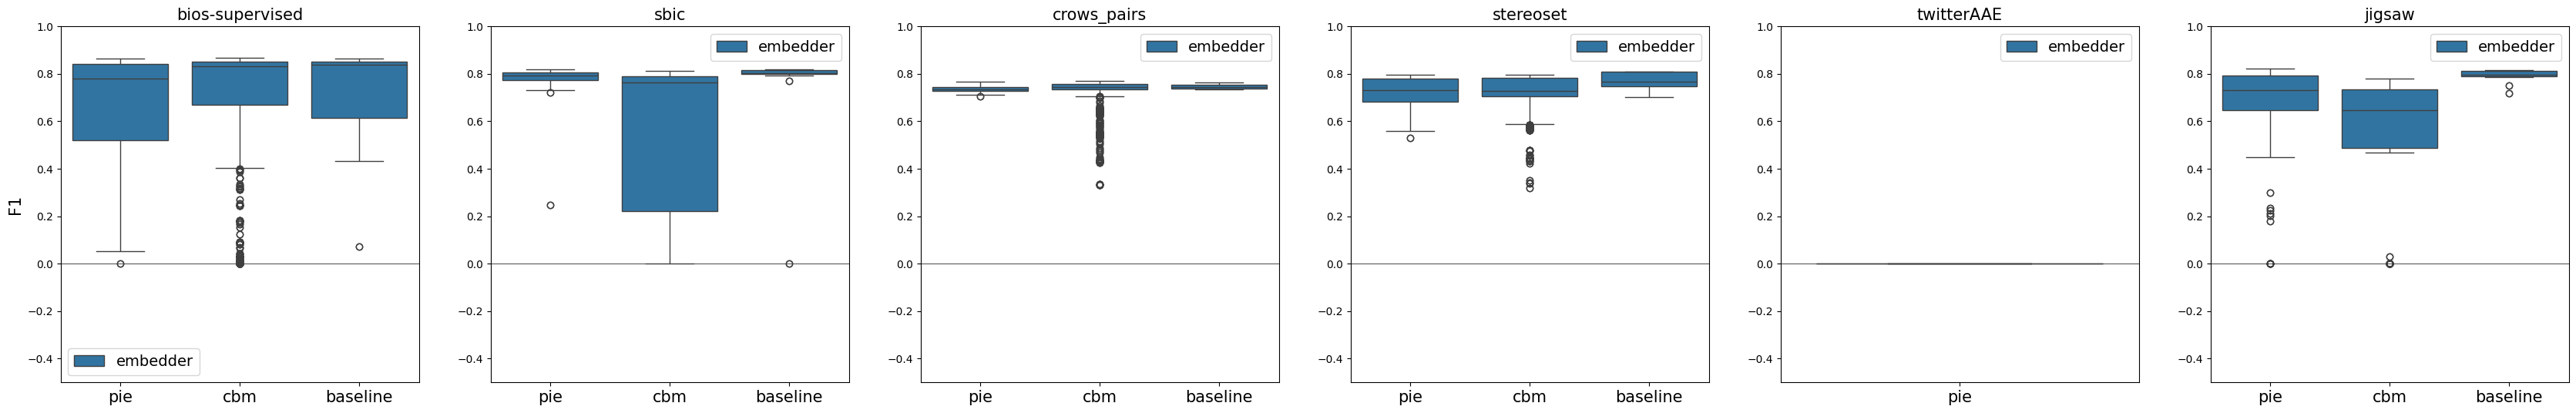

In [93]:
multipot(res_perf, subplot_col='dataset', xcol='method', ycol='F1', huecol='architecture', remove_legend=False, savefile='plots/performance_arch.eps')

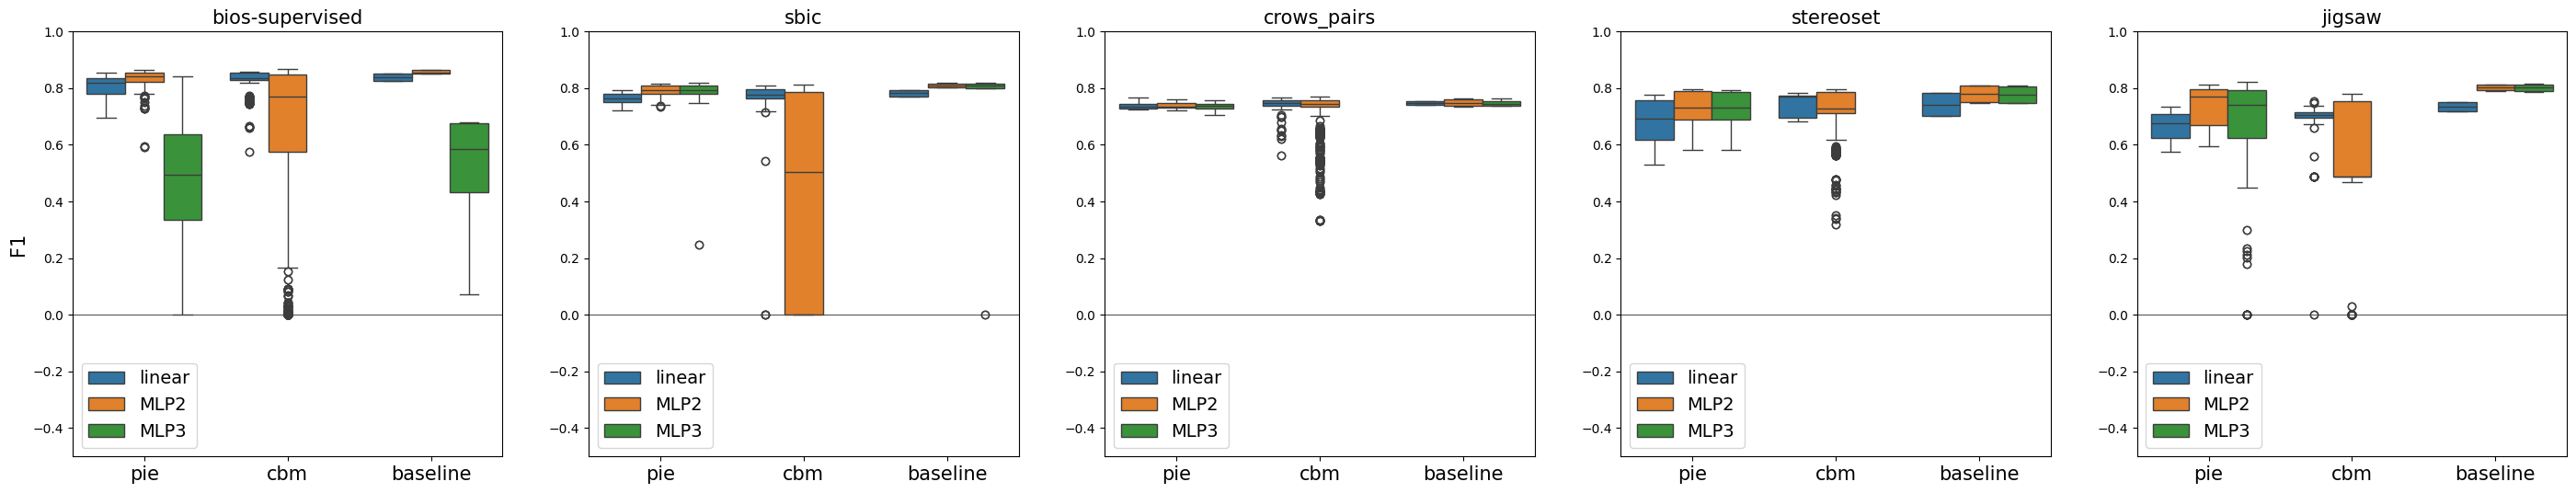

In [121]:
multipot(res_perf[res_perf['dataset'] != 'twitterAAE'], subplot_col='dataset', xcol='method', ycol='F1', huecol='classifier', remove_legend=False, savefile='plots/performance_clf.png')

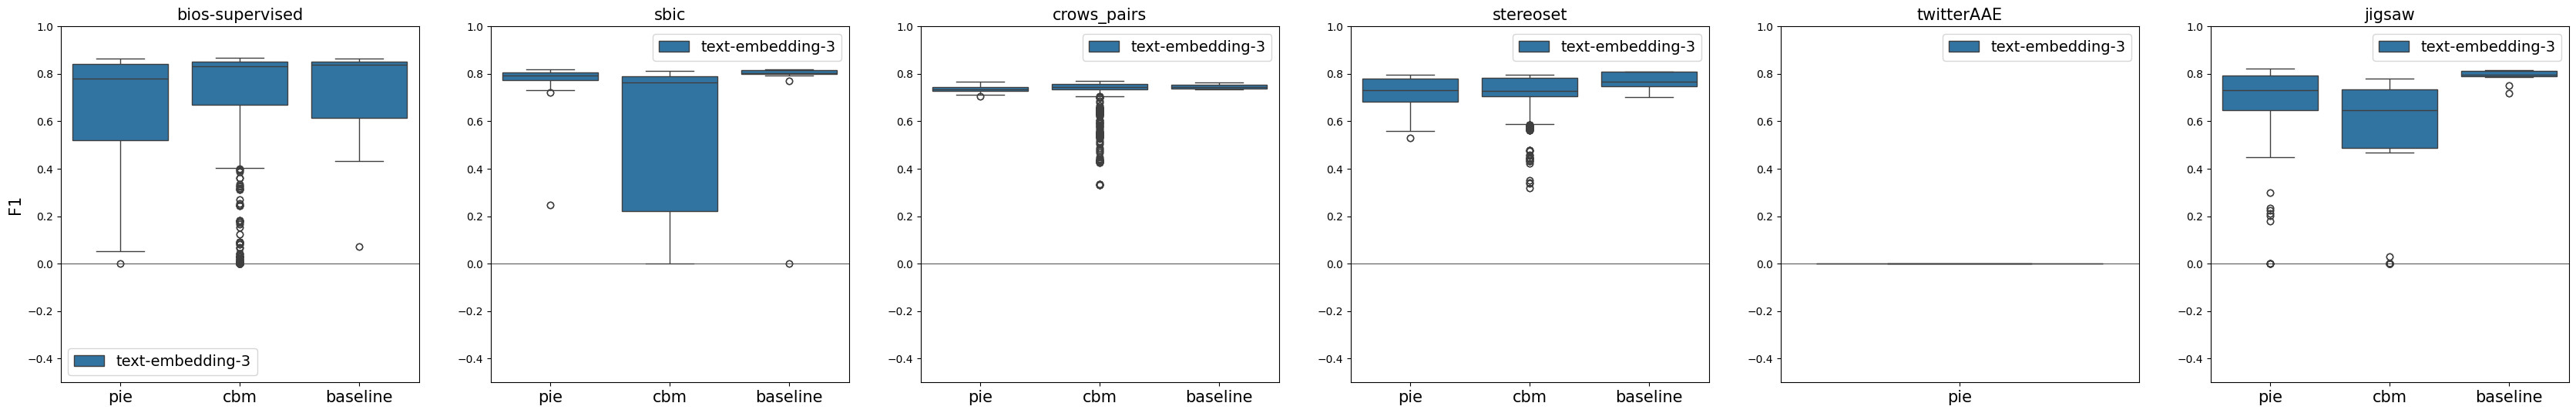

In [13]:
multipot(res_perf, subplot_col='dataset', xcol='method', ycol='F1', huecol='model type', remove_legend=False)

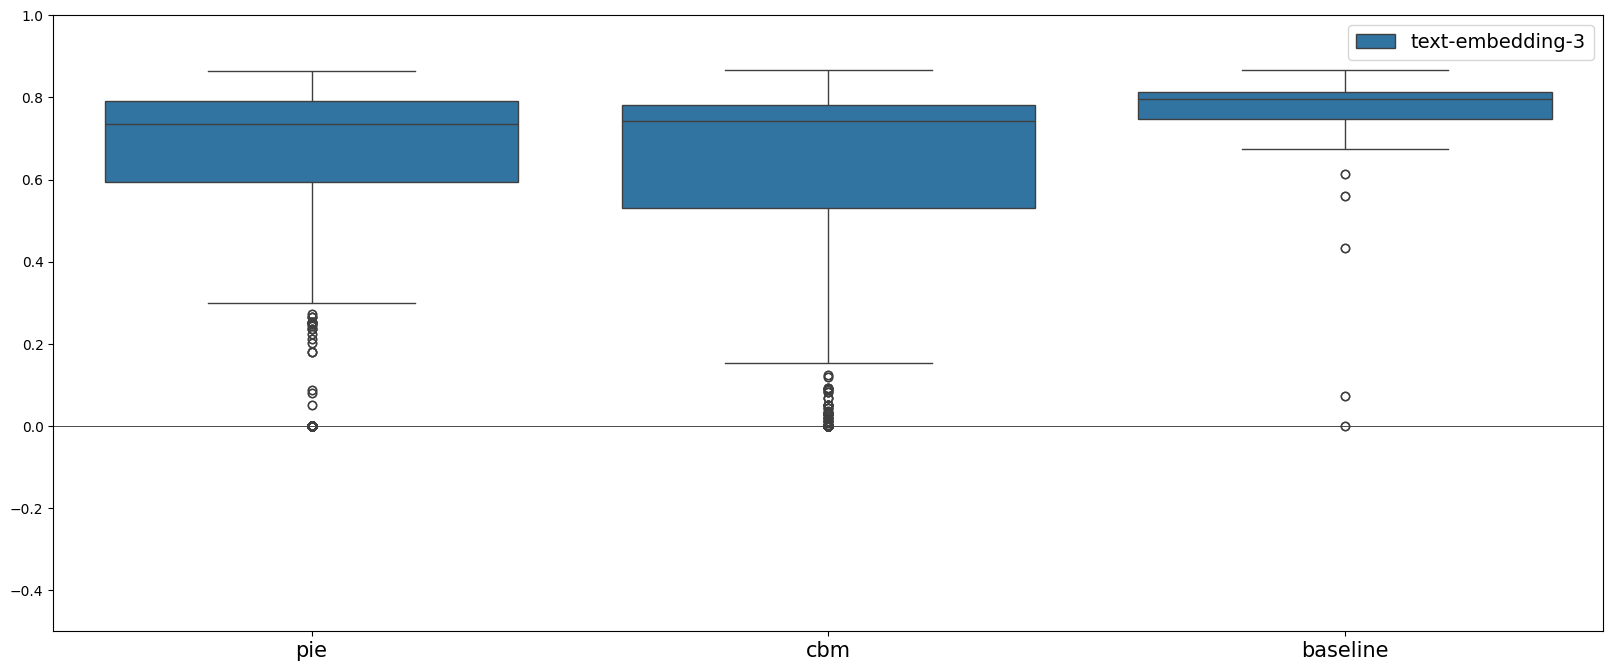

In [14]:
res = res_perf[res_perf['classifier'] != 'linear']

fig, ax = plt.subplots(figsize=(20,8))
boxplot(res, ax, xcol='method', ycol='F1', huecol='model type', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

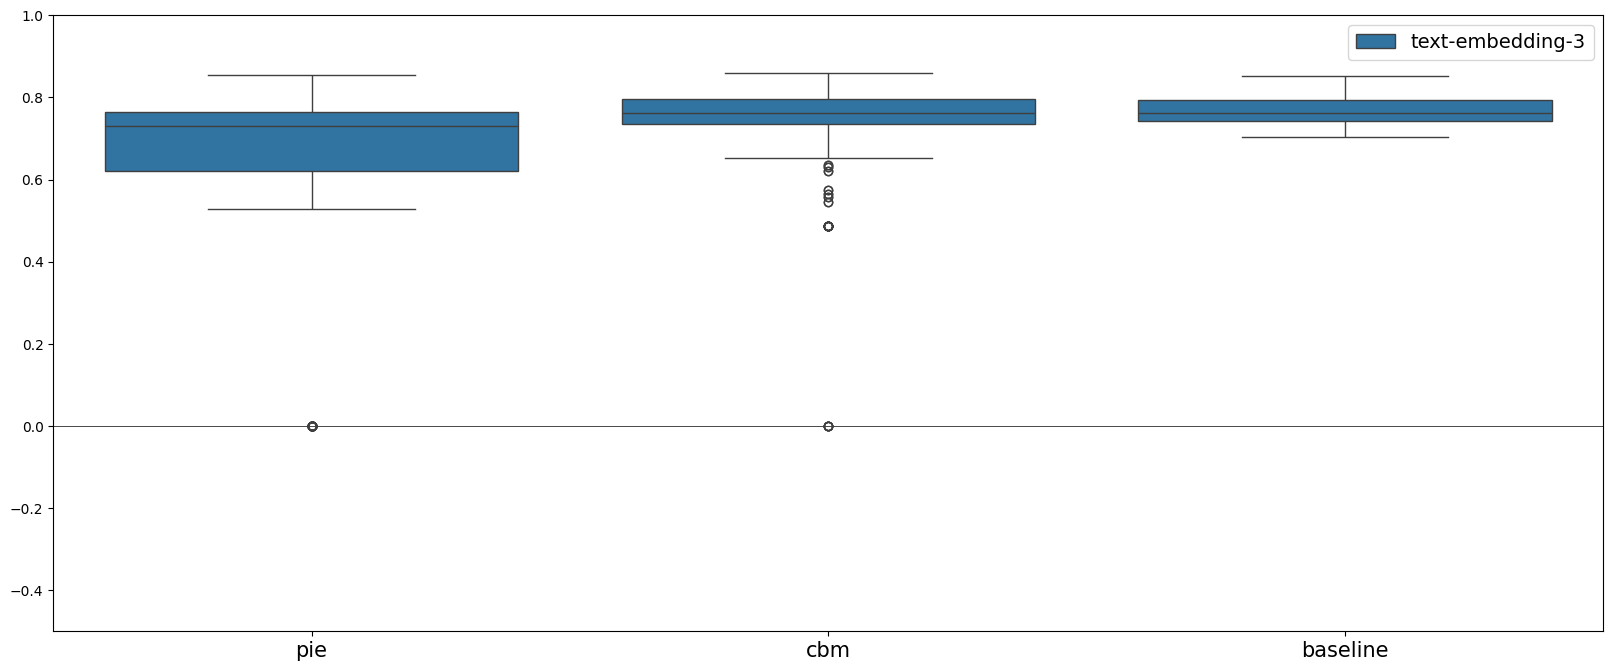

In [15]:
res = res_perf[res_perf['classifier'] == 'linear']

fig, ax = plt.subplots(figsize=(20,8))
boxplot(res, ax, xcol='method', ycol='F1', huecol='model type', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

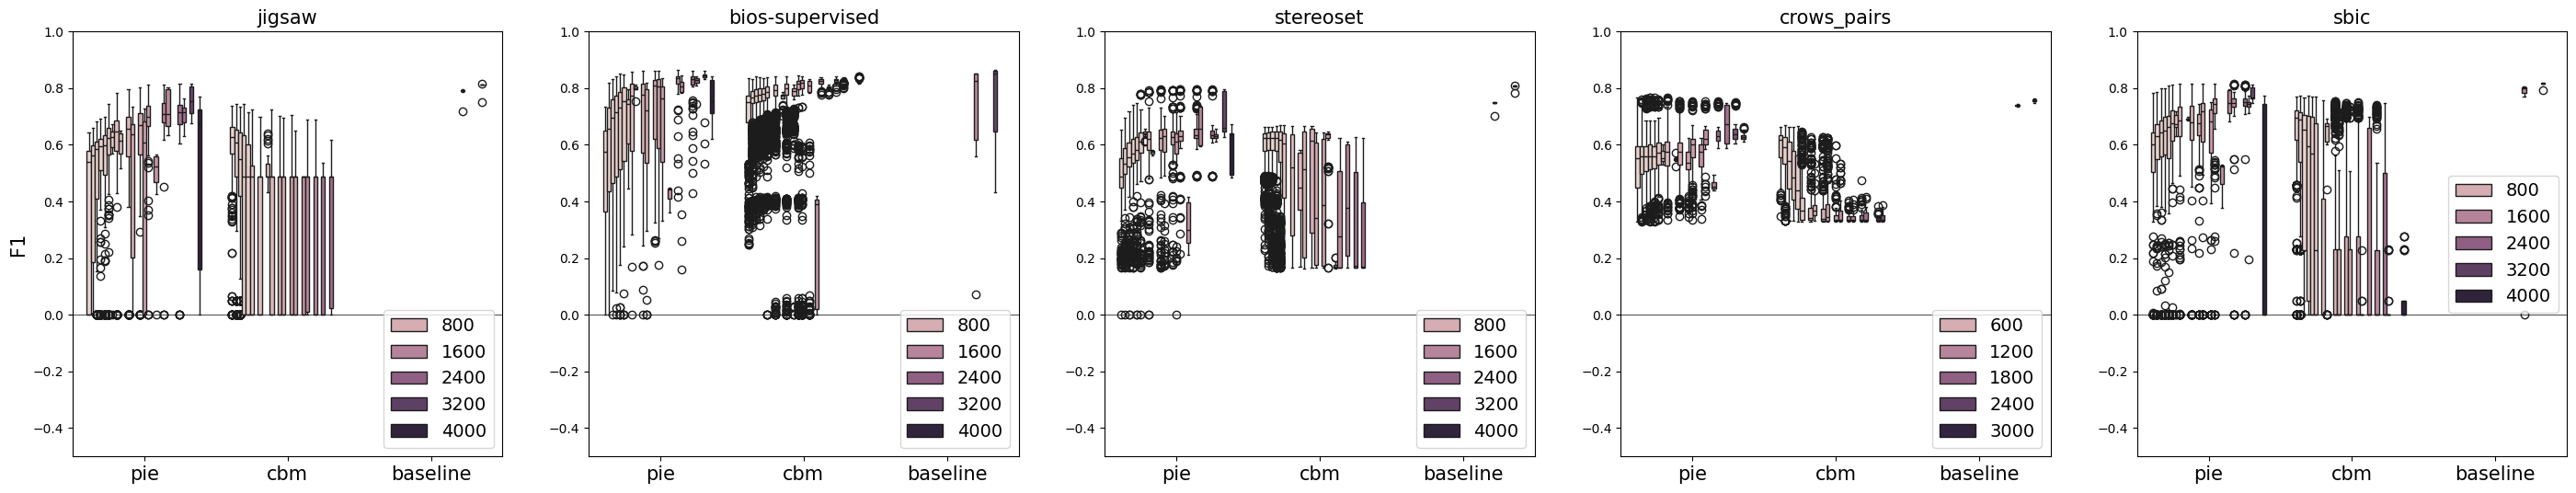

In [14]:
multipot(res_perf, subplot_col='dataset', xcol='method', ycol='F1', huecol='other concepts', remove_legend=False)

In [20]:
res_cbm_concept.columns

Index(['index', 'dataset', 'model', 'model type', 'architecture', 'method',
       'pooling', 'classifier', 'clf hidden size factor', 'emb size',
       'protected concepts', 'other concepts', 'optimizer', 'lr', 'loss',
       'group (test)', 'Pearson R', 'pvalue', 'PR-AUC', 'Epochs', 'concepts'],
      dtype='object')

KeyError: 'Column not found: PR-AUC'

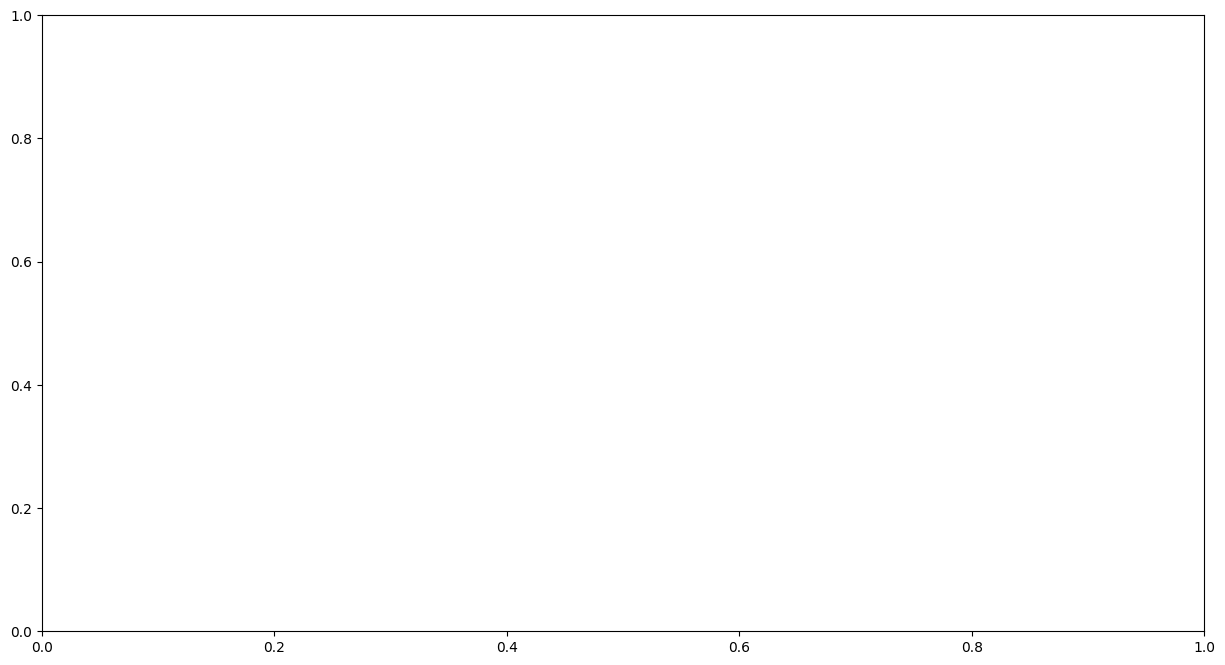

In [100]:
def aggregate_results(results, sel_cols, target_col):
    grouped_res = results.groupby(sel_cols, as_index=False)[target_col].mean().reset_index()
    grouped_res[target_col+' var'] = results.groupby(sel_cols, as_index=False)[target_col].var()[target_col]
    return grouped_res

fig, ax = plt.subplots(figsize=(15,8))
for clf in ['linear', 'MLP2']:
    res_cbm_ = aggregate_results(res_cbm[res_cbm['classifier'] == clf], sel_cols=['lambda'], target_col='F1')
    conc_cbm_ = aggregate_results(results_cbm_concept[results_cbm_concept['classifier'] == clf], sel_cols=['lambda'], target_col='PR-AUC')
    
    ax.errorbar(x=res_cbm_['lambda'], y=res_cbm_['F1'], yerr=res_cbm_['F1 var'], label='Classes (%s)' % clf)
    ax.errorbar(x=conc_cbm_['lambda'], y=conc_cbm_['PR-AUC'], yerr=conc_cbm_['PR-AUC var'], label='Concepts (%s)' % clf)
    ax.set_xlabel('lambda')
    ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
for dataset in ['sbic', 'bios-supervised']:
    res_cbm_ = aggregate_results(res_cbm[res_cbm['dataset'] == dataset], sel_cols=['lambda'], target_col='F1')
    conc_cbm_ = aggregate_results(results_cbm_concept[results_cbm_concept['dataset'] == dataset], sel_cols=['lambda'], target_col='PR-AUC')
    
    ax.errorbar(x=res_cbm_['lambda'], y=res_cbm_['F1'], yerr=res_cbm_['F1 var'], label='Classes (%s)' % dataset)
    ax.errorbar(x=conc_cbm_['lambda'], y=conc_cbm_['PR-AUC'], yerr=conc_cbm_['PR-AUC var'], label='Concepts (%s)' % dataset)
    ax.set_xlabel('lambda')
    ax.legend()

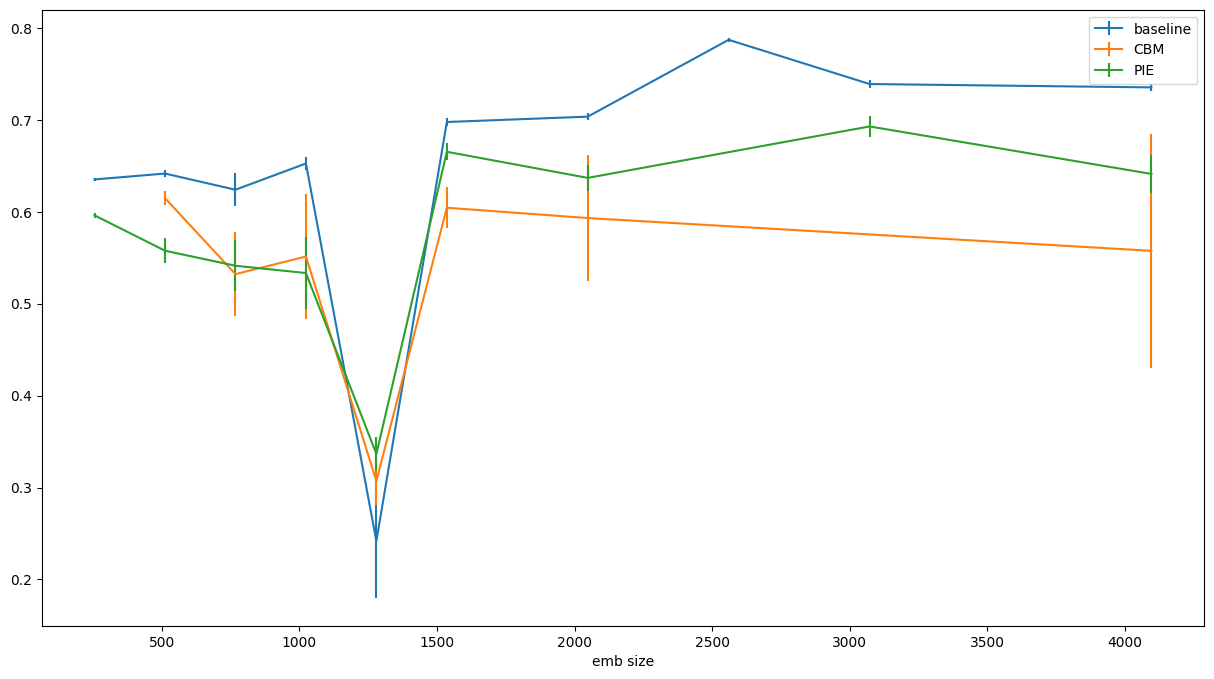

In [101]:
def aggregate_results(results, sel_cols, target_col):
    grouped_res = results.groupby(sel_cols, as_index=False)[target_col].mean().reset_index()
    grouped_res[target_col+' var'] = results.groupby(sel_cols, as_index=False)[target_col].var()[target_col]
    return grouped_res

res_base_ = aggregate_results(res_base[res_base['classifier'] == 'linear'], sel_cols=['emb size'], target_col='F1')
res_cbm_ = aggregate_results(res_cbm[res_cbm['classifier'] == 'linear'], sel_cols=['emb size'], target_col='F1')
res_pie_ = aggregate_results(res_pie[res_pie['classifier'] == 'linear'], sel_cols=['emb size'], target_col='F1')


fig, ax = plt.subplots(figsize=(15,8))
ax.errorbar(x=res_base_['emb size'], y=res_base_['F1'], yerr=res_base_['F1 var'], label='baseline')
ax.errorbar(x=res_cbm_['emb size'], y=res_cbm_['F1'], yerr=res_cbm_['F1 var'], label='CBM')
ax.errorbar(x=res_pie_['emb size'], y=res_pie_['F1'], yerr=res_pie_['F1 var'], label='PIE')
ax.set_xlabel('emb size')
ax.legend()

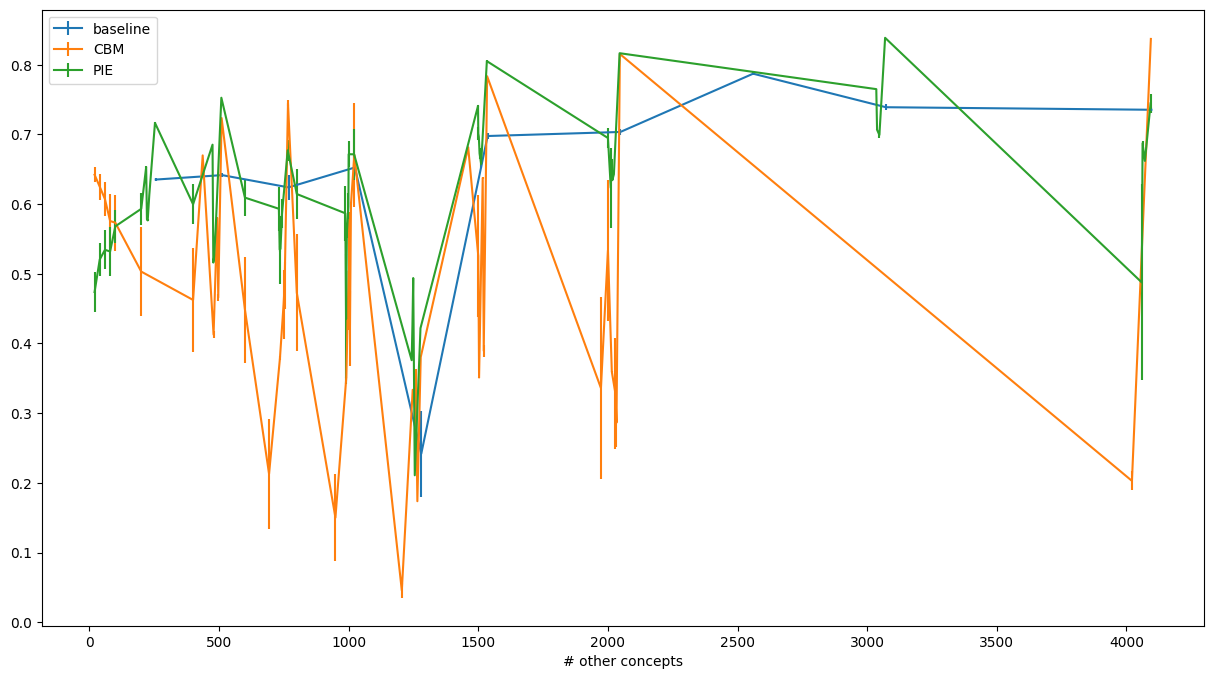

In [102]:
def aggregate_results(results, sel_cols, target_col):
    grouped_res = results.groupby(sel_cols, as_index=False)[target_col].mean().reset_index()
    grouped_res[target_col+' var'] = results.groupby(sel_cols, as_index=False)[target_col].var()[target_col]
    return grouped_res

res_base_ = aggregate_results(res_base[res_base['classifier'] == 'linear'], sel_cols=['other concepts'], target_col='F1')
res_cbm_ = aggregate_results(res_cbm[res_cbm['classifier'] == 'linear'], sel_cols=['other concepts'], target_col='F1')
res_pie_ = aggregate_results(res_pie[res_pie['classifier'] == 'linear'], sel_cols=['other concepts'], target_col='F1')


fig, ax = plt.subplots(figsize=(15,8))
ax.errorbar(x=res_base_['other concepts'], y=res_base_['F1'], yerr=res_base_['F1 var'], label='baseline')
ax.errorbar(x=res_cbm_['other concepts'], y=res_cbm_['F1'], yerr=res_cbm_['F1 var'], label='CBM')
ax.errorbar(x=res_pie_['other concepts'], y=res_pie_['F1'], yerr=res_pie_['F1 var'], label='PIE')
ax.set_xlabel('# other concepts')
ax.legend()

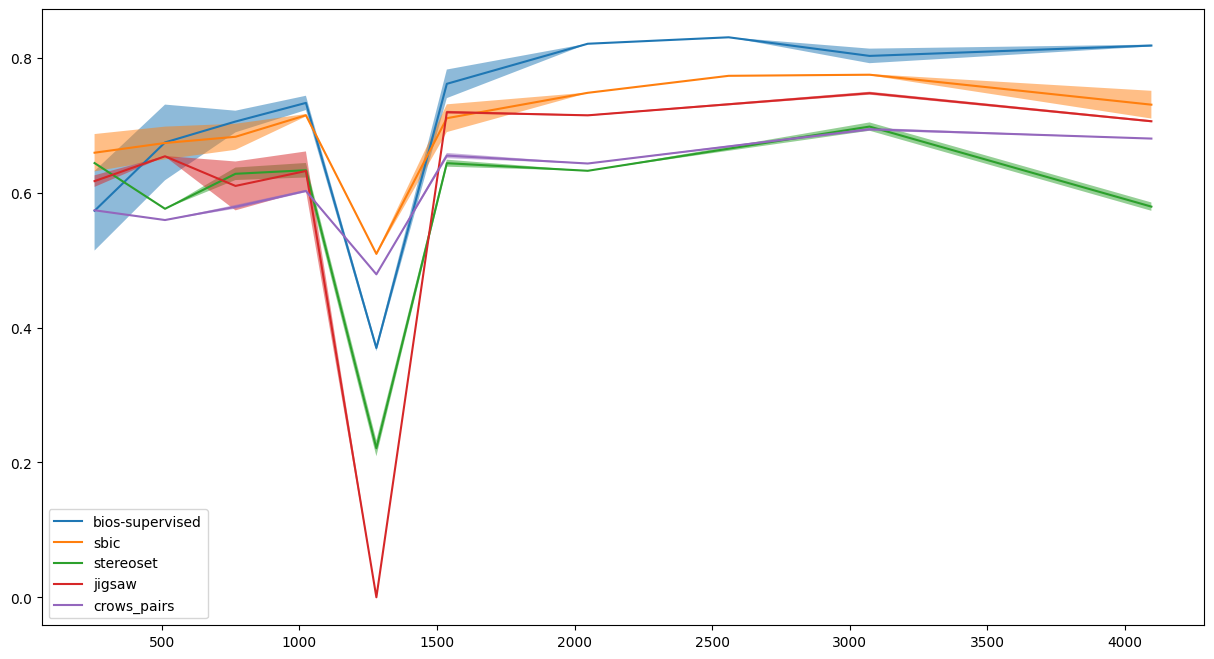

In [103]:
fig, ax = plt.subplots(figsize=(15,8))

for dataset in ['bios-supervised', 'sbic', 'stereoset', 'jigsaw', 'crows_pairs']:
    res_ = aggregate_results(res_base[res_base['dataset'] == dataset], sel_cols=['other concepts'], target_col='F1')
    y1 = res_['F1']-res_['F1 var']
    y2 = res_['F1']+res_['F1 var']

    ax.fill_between(res_['other concepts'], y1, y2, alpha=.5, linewidth=0)
    ax.plot(res_['other concepts'], res_['F1'], label=dataset)
ax.legend()

## Performance by number of other concepts

### 1) CBM

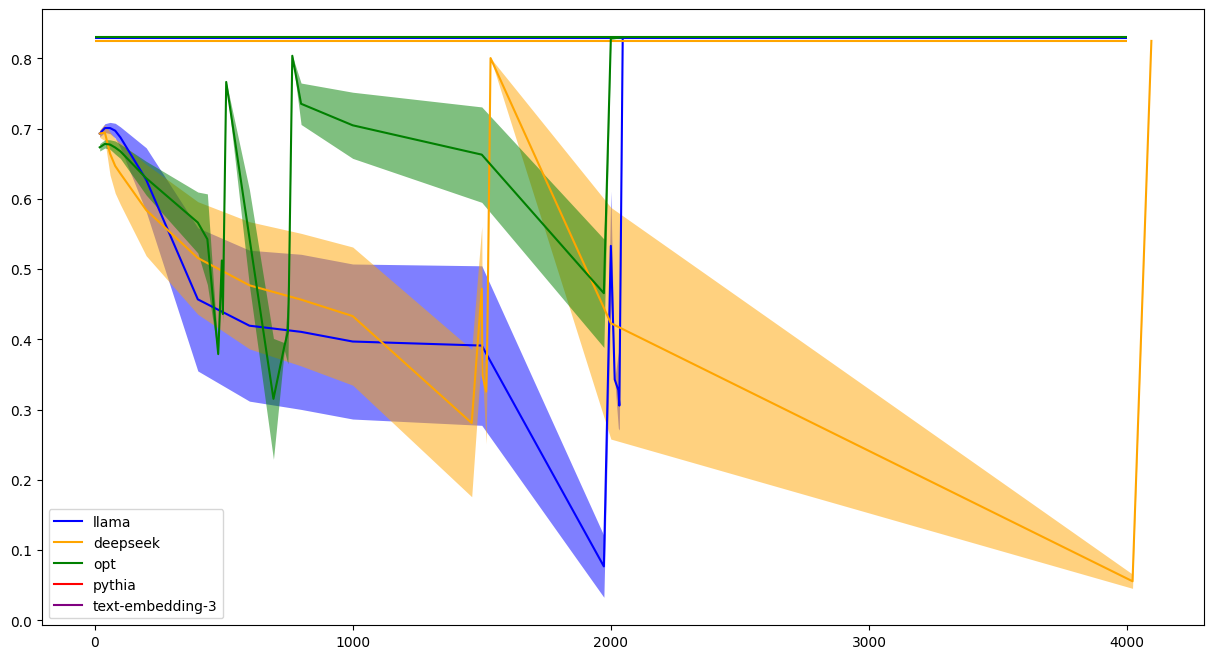

In [104]:
fig, ax = plt.subplots(figsize=(15,8))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'pink', 'brown']
for i, model_type in enumerate(['llama', 'deepseek', 'opt', 'pythia', 'text-embedding-3']):
    res_ = res_cbm[res_cbm['model type'] == model_type]
    res_agg = aggregate_results(res_, sel_cols=['other concepts'], target_col='F1')

    max_y = np.max(res_agg['F1'])
    ax.hlines([max_y], xmin=0, xmax=4000, colors=colors[i])
    
    y1 = res_agg['F1']-res_agg['F1 var']
    y2 = res_agg['F1']+res_agg['F1 var']
    ax.fill_between(res_agg['other concepts'], y1, y2, alpha=.5, linewidth=0, color=colors[i])
    ax.plot(res_agg['other concepts'], res_agg['F1'], label=model_type, color=colors[i])
ax.legend()

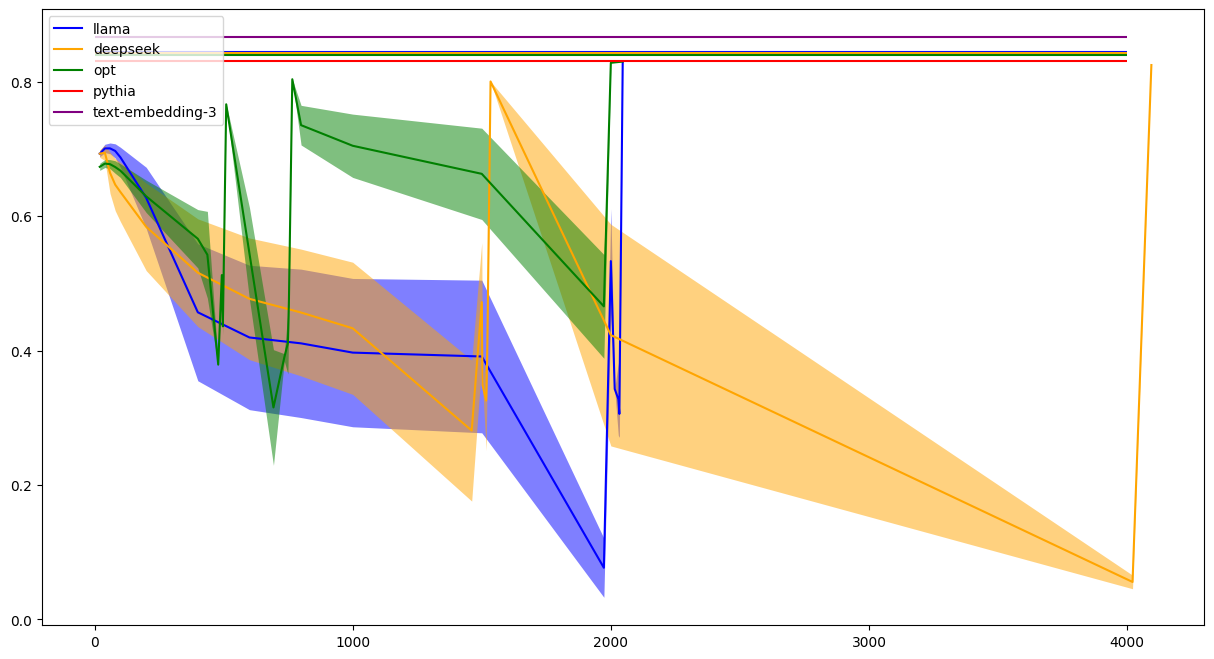

In [105]:
fig, ax = plt.subplots(figsize=(15,8))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'pink', 'brown']
for i, model_type in enumerate(['llama', 'deepseek', 'opt', 'pythia', 'text-embedding-3']):
    res_ = res_cbm[res_cbm['model type'] == model_type]
    res_agg = aggregate_results(res_, sel_cols=['other concepts'], target_col='F1')

    max_y = np.max(res_base[res_base['model type'] == model_type]['F1'])
    ax.hlines([max_y], xmin=0, xmax=4000, colors=colors[i])
    
    y1 = res_agg['F1']-res_agg['F1 var']
    y2 = res_agg['F1']+res_agg['F1 var']
    ax.fill_between(res_agg['other concepts'], y1, y2, alpha=.5, linewidth=0, color=colors[i])
    ax.plot(res_agg['other concepts'], res_agg['F1'], label=model_type, color=colors[i])
ax.legend()

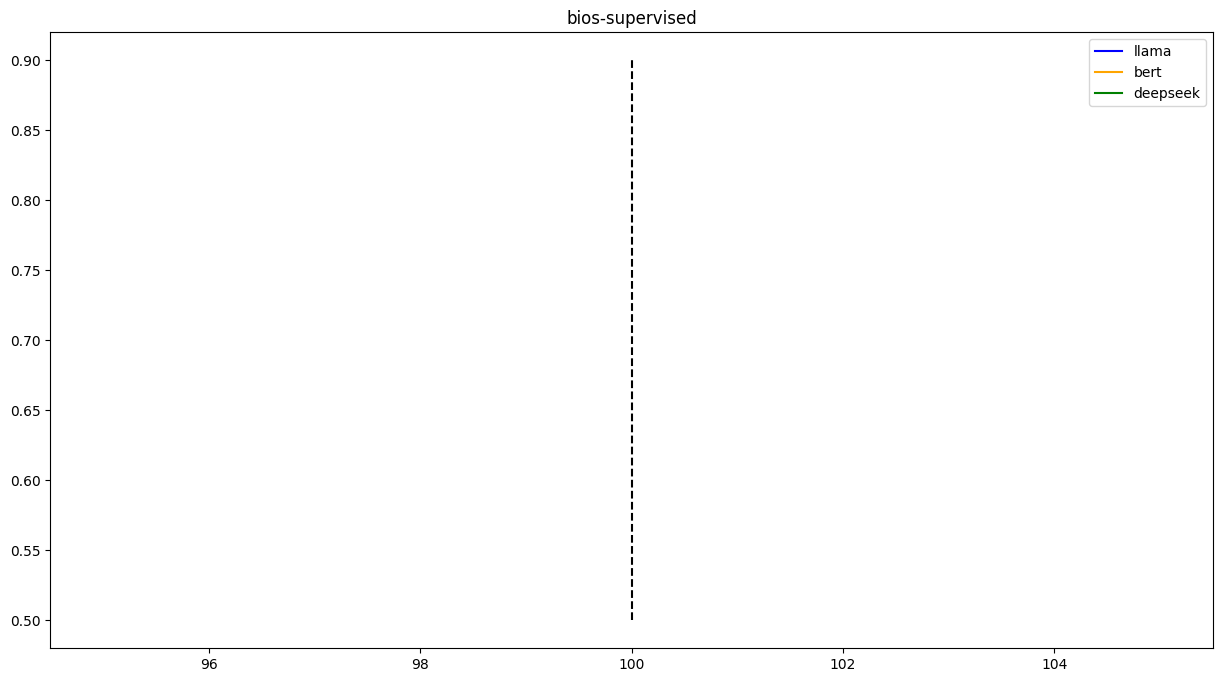

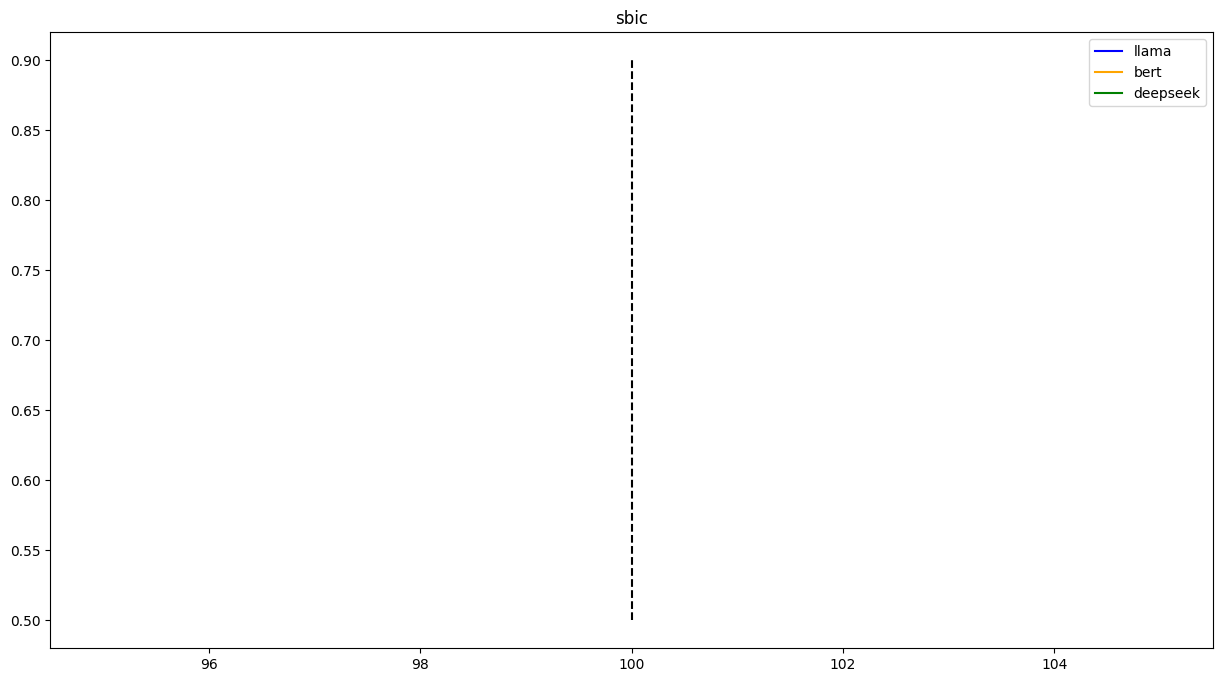

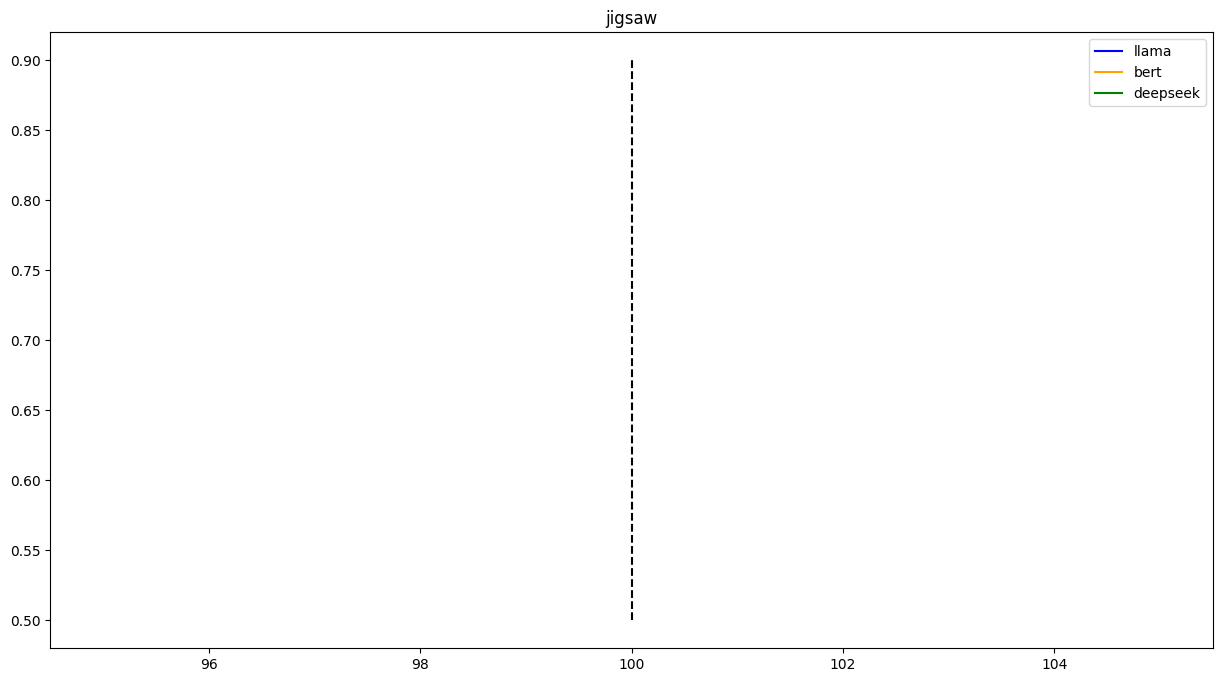

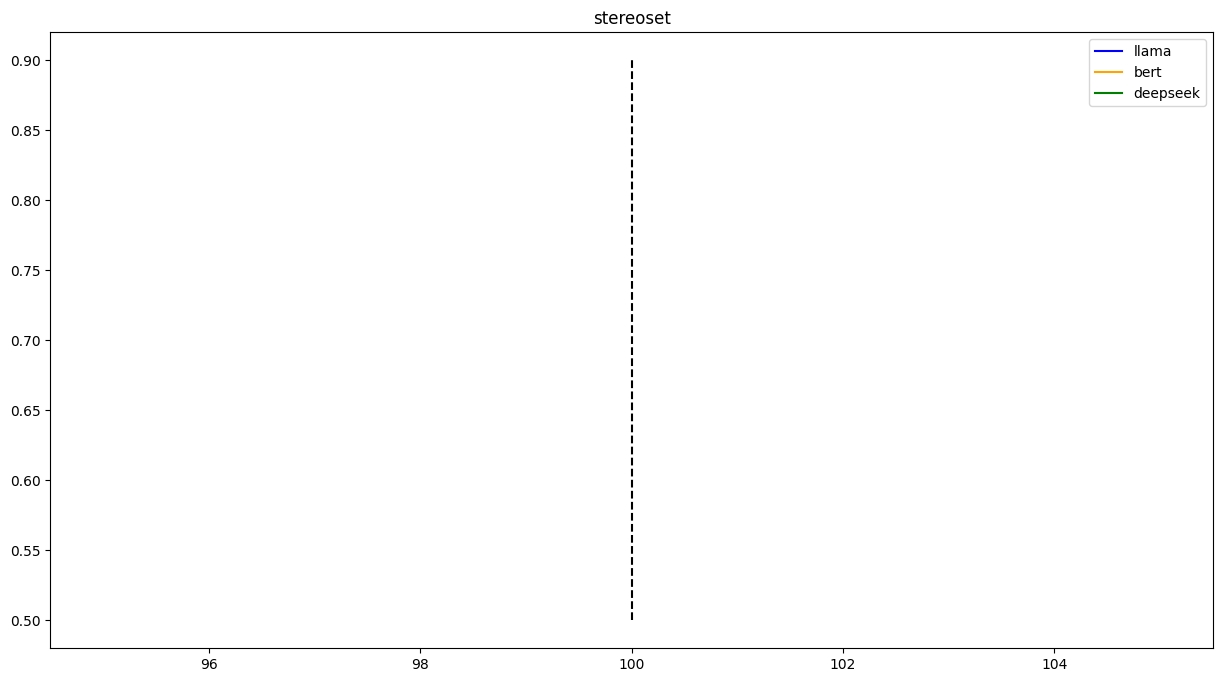

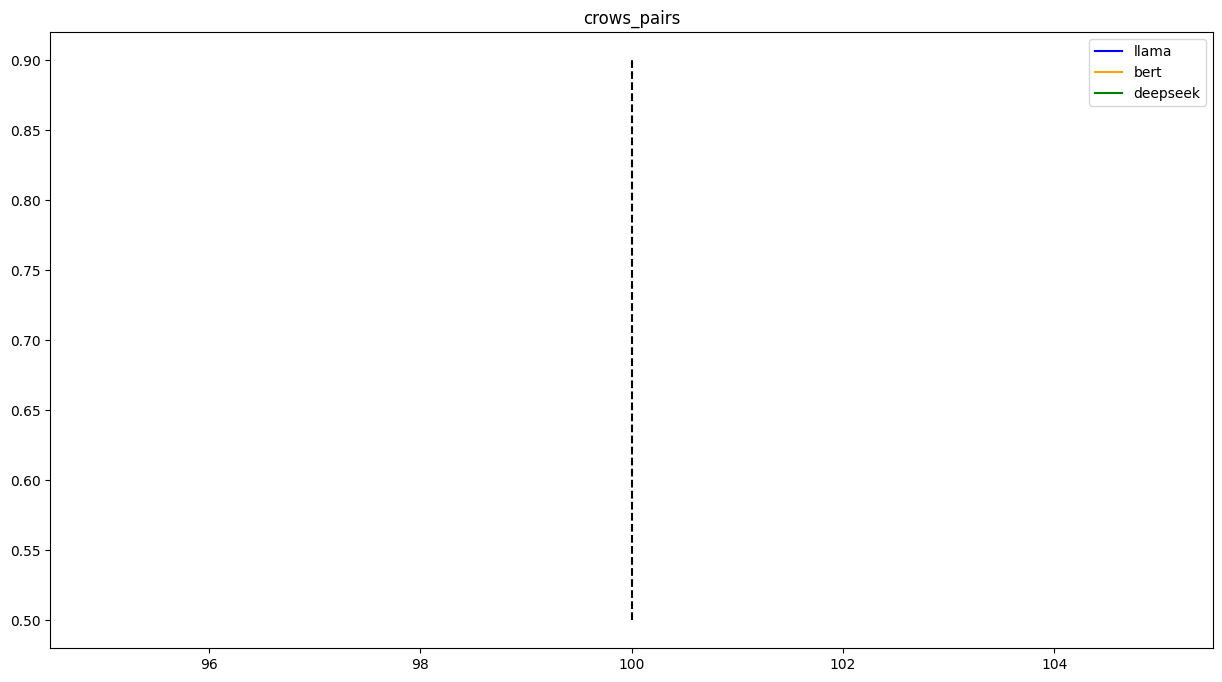

In [328]:
for dataset in ['bios-supervised', 'sbic', 'jigsaw', 'stereoset', 'crows_pairs']:
    fig, ax = plt.subplots(figsize=(15,8))
    res_base_ = res_base[res_base['dataset'] == dataset]
    res_base_ = aggregate_results(res_base_, sel_cols=['model type'], target_col='F1')
    ax.vlines(100, 0.5, 0.9, linestyle='--', colors='black')
    
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'pink', 'brown']
    for i, model_type in enumerate(['llama', 'bert', 'deepseek']):#, 'text-embedding-3']):
        res_ = res_cbm[res_cbm['classifier'] == 'linear']
        res_ = res_cbm[res_cbm['model type'] == model_type]
        res_ = res_[res_['dataset'] == dataset]
        res_agg = aggregate_results(res_, sel_cols=['other concepts'], target_col='F1')

        emb_sizes = list(set(res_['emb size']))
        ax.vlines(emb_sizes, 0.5, 0.9, linestyle='--', colors=colors[i])
    
        max_y = np.max(res_base_[res_base_['model type'] == model_type]['F1'])
        ax.hlines([max_y], xmin=0, xmax=4000, colors=colors[i])
        
        y1 = res_agg['F1']-res_agg['F1 var']
        y2 = res_agg['F1']+res_agg['F1 var']
        ax.fill_between(res_agg['other concepts'], y1, y2, alpha=.5, linewidth=0, color=colors[i])
        ax.plot(res_agg['other concepts'], res_agg['F1'], label=model_type, color=colors[i])
    ax.legend()
    ax.set_title(dataset)

### 2) PIE

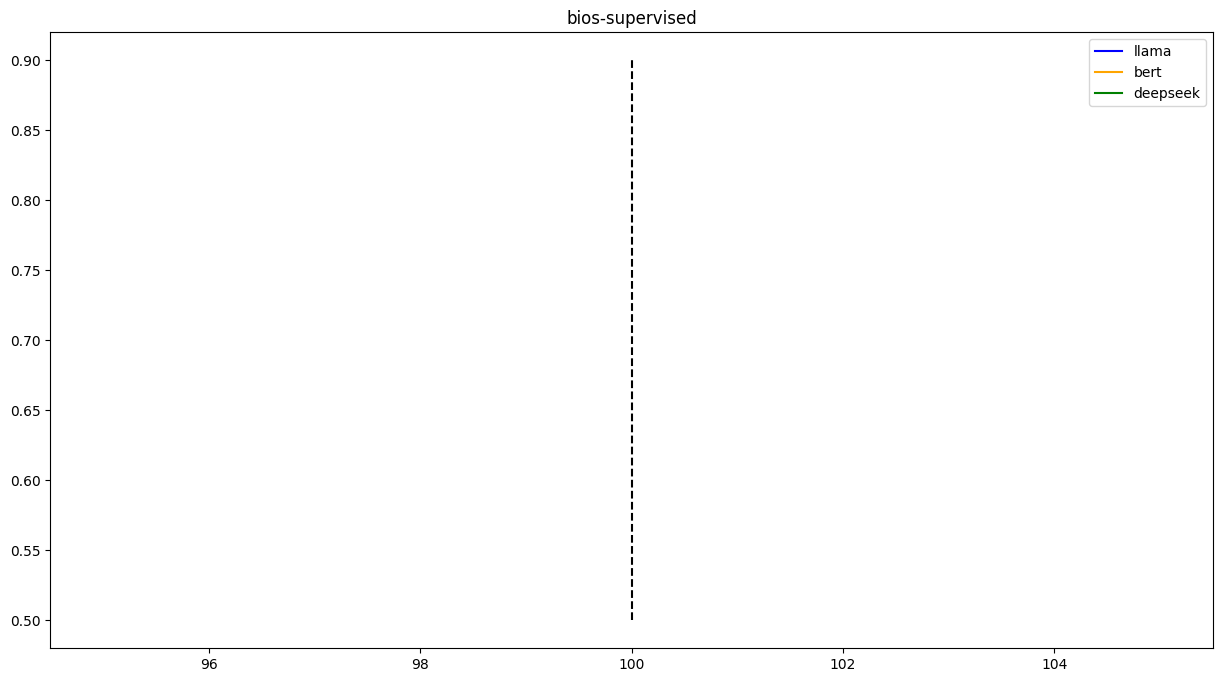

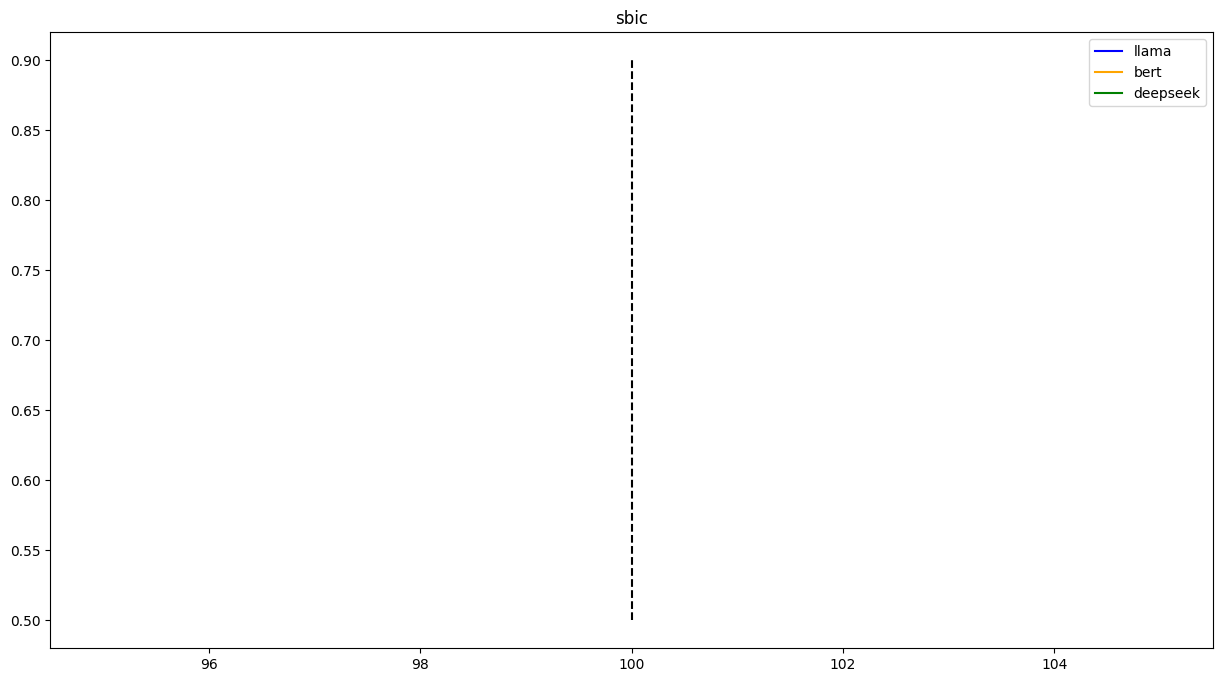

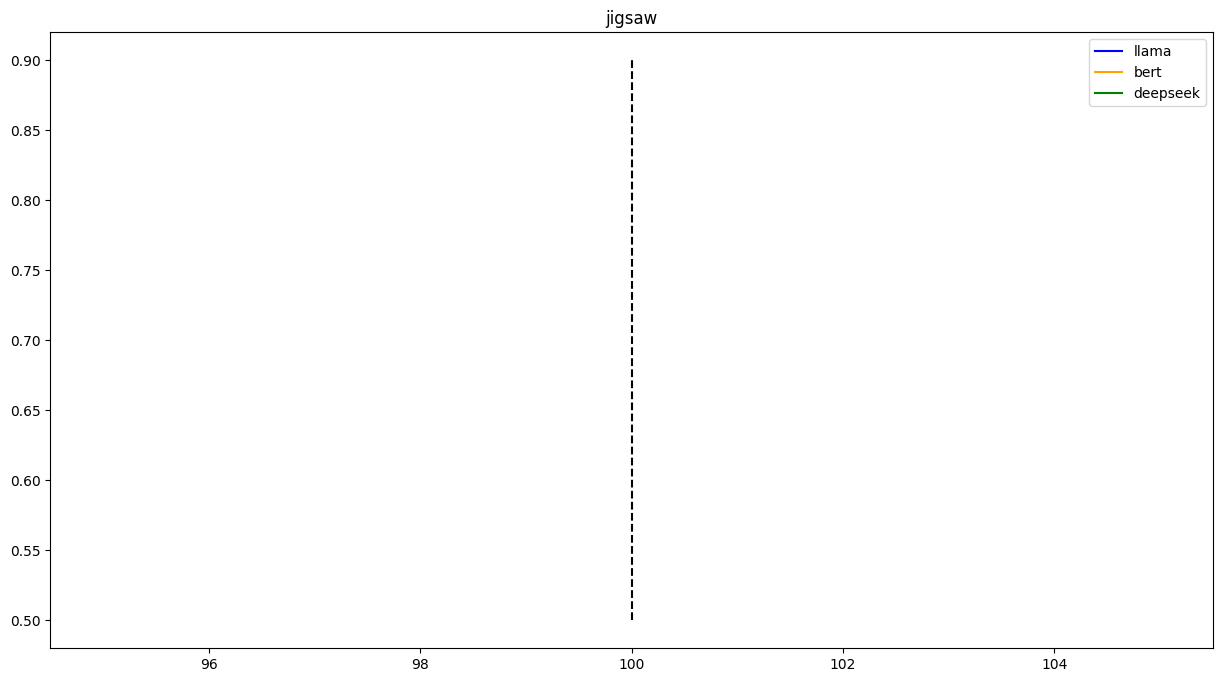

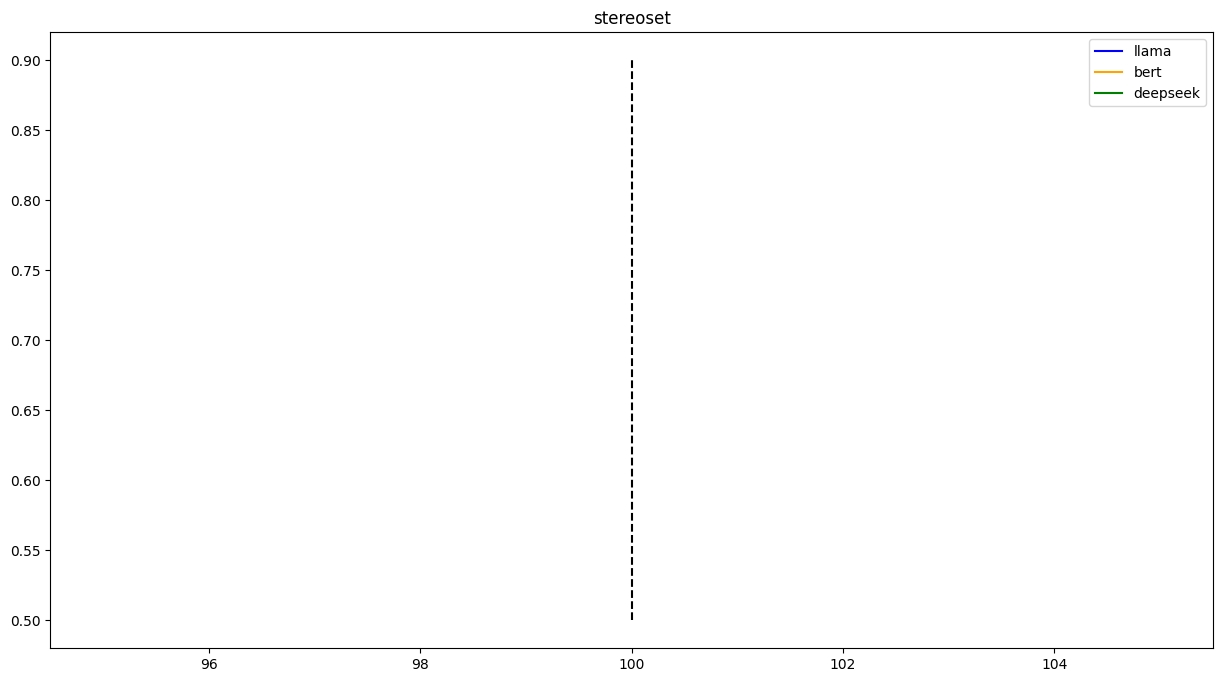

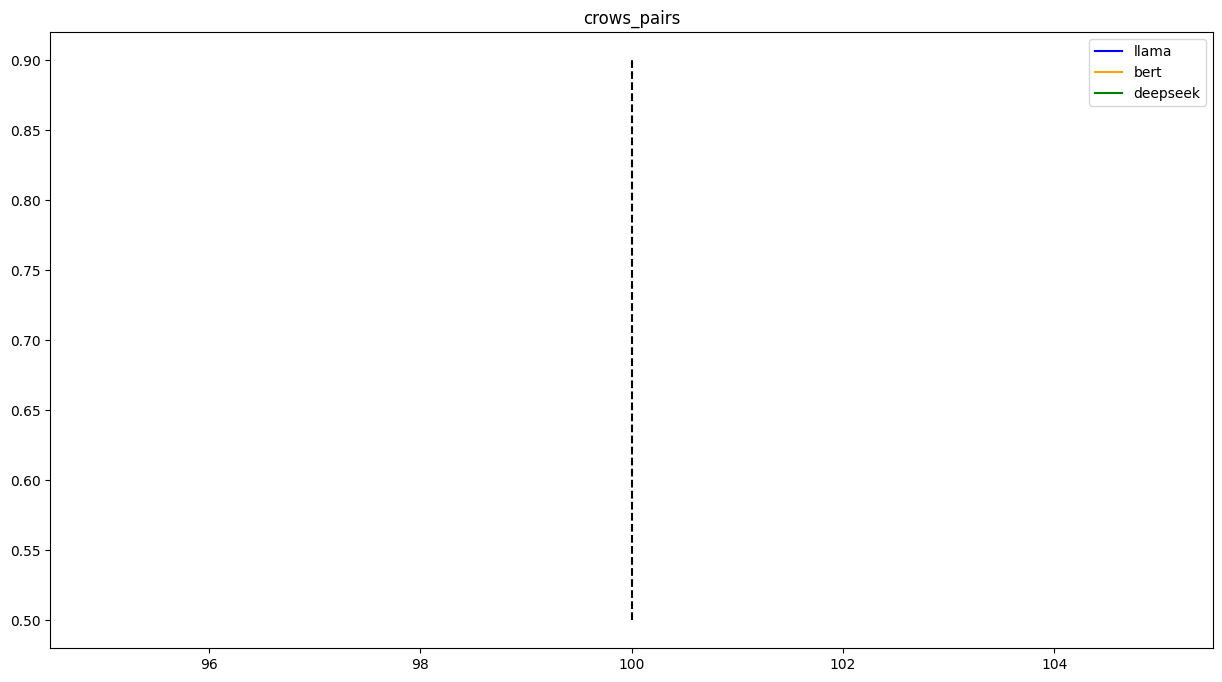

In [13]:
for dataset in ['bios-supervised', 'sbic', 'jigsaw', 'stereoset', 'crows_pairs']:
    fig, ax = plt.subplots(figsize=(15,8))
    res_base_ = res_base[res_base['dataset'] == dataset]
    res_base_ = aggregate_results(res_base_, sel_cols=['model type'], target_col='F1')
    ax.vlines(100, 0.5, 0.9, linestyle='--', colors='black')
    
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'pink', 'brown']
    for i, model_type in enumerate(['llama', 'bert', 'deepseek']): #, 'opt', 'pythia']):#, 'text-embedding-3']):
        res_ = res_pie[res_pie['model type'] == model_type]
        res_ = res_[res_['dataset'] == dataset]
        res_agg = aggregate_results(res_, sel_cols=['other concepts'], target_col='F1')
        
        emb_sizes = list(set(res_['emb size']))
        ax.vlines(emb_sizes, 0.5, 0.9, linestyle='--', colors=colors[i])
    
        #max_y = np.max(res_agg['F1'])
        max_y = np.max(res_base[res_base['model type'] == model_type]['F1'])
        ax.hlines([max_y], xmin=0, xmax=4000, colors=colors[i])
        
        y1 = res_agg['F1']-res_agg['F1 var']
        y2 = res_agg['F1']+res_agg['F1 var']
        ax.fill_between(res_agg['other concepts'], y1, y2, alpha=.5, linewidth=0, color=colors[i])
        ax.plot(res_agg['other concepts'], res_agg['F1'], label=model_type, color=colors[i])
    ax.legend()
    ax.set_title(dataset)

In [ ]:
for dataset in ['bios-supervised', 'sbic', 'jigsaw', 'stereoset', 'crows_pairs']:
    fig, ax = plt.subplots(figsize=(15,8))
    res_base_ = res_base[res_base['dataset'] == dataset]
    res_base_ = aggregate_results(res_base_, sel_cols=['model type'], target_col='F1')
    ax.vlines(100, 0.5, 0.9, linestyle='--', colors='black')
    
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'pink', 'brown']
    for i, model_type in enumerate(['llama', 'bert', 'deepseek', 'text-embedding-3']):#, 'text-embedding-3']):
        res_ = res_pie[res_pie['model type'] == model_type]
        res_ = res_[res_['dataset'] == dataset]
        res_agg = aggregate_results(res_, sel_cols=['other concepts'], target_col='F1')

        emb_sizes = list(set(res_['emb size']))
        ax.vlines(emb_sizes, 0.5, 0.9, linestyle='--', colors=colors[i])
    
        max_y = np.max(res_base_[res_base_['model type'] == model_type]['F1'])
        ax.hlines([max_y], xmin=0, xmax=4000, colors=colors[i])
        
        y1 = res_agg['F1']-res_agg['F1 var']
        y2 = res_agg['F1']+res_agg['F1 var']
        ax.fill_between(res_agg['other concepts'], y1, y2, alpha=.5, linewidth=0, color=colors[i])
        ax.plot(res_agg['other concepts'], res_agg['F1'], label=model_type, color=colors[i])
    ax.legend()
    ax.set_title(dataset)

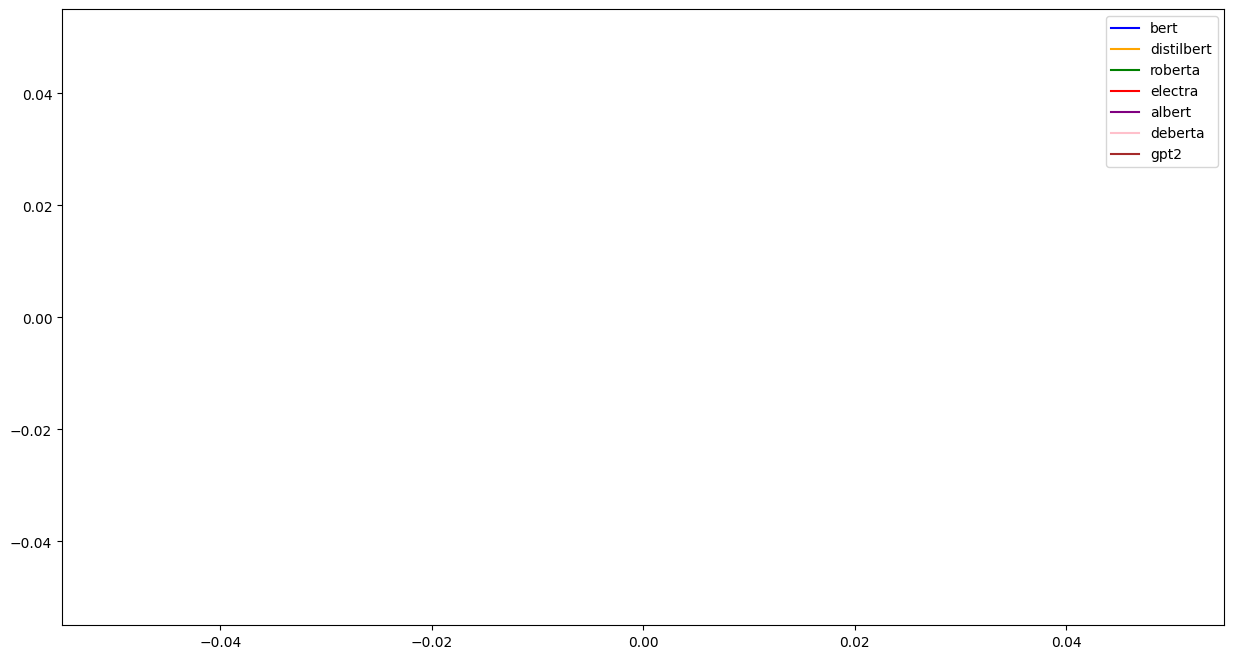

In [332]:
fig, ax = plt.subplots(figsize=(15,8))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'pink', 'brown']
for i, model_type in enumerate(['bert', 'distilbert', 'roberta', 'electra', 'albert', 'deberta', 'gpt2']):
    res_ = res_pie[res_pie['model type'] == model_type]
    res_agg = aggregate_results(res_, sel_cols=['other concepts'], target_col='F1')

    max_y = np.max(res_agg['F1'])
    ax.hlines([max_y], xmin=0, xmax=1500, colors=colors[i])
    
    y1 = res_agg['F1']-res_agg['F1 var']
    y2 = res_agg['F1']+res_agg['F1 var']
    ax.fill_between(res_agg['other concepts'], y1, y2, alpha=.5, linewidth=0, color=colors[i])
    ax.plot(res_agg['other concepts'], res_agg['F1'], label=model_type, color=colors[i])
ax.legend()

In [114]:
def group2attr(group):
    if group in ['white', 'black', 'asian', 'latin-american', 'hispanic', 'middle eastern', 'african', 'hispanic/latino', 'middle east', 'south east asian', 'latino', 'european']:
        return 'ethnicity'
    if group in ['male', 'female', 'trans', 'lgbtq+', 'transgender']:
        return 'gender'
    if group in ['homosexual', 'bisexual', 'heterosexual', 'homosexual_gay_or_lesbian']:
        return 'sex_or'
    if group in ['christian', 'muslim/islam', 'muslim', 'jewish']:
        return 'religion'
    if group in ['disability', 'intellectual_or_learning_disability', 'mental disability', 'mental illness', 'mental illness/ disorder', 'physical disability', 'physical_disability', 'psychiatric_or_mental_illness']:
        return 'disability'
    return 'n/a'

res_concept['attribute'] = ''
for idx in res_concept.index:
    res_concept.loc[idx, 'attribute'] = group2attr(res_concept.loc[idx,'group (test)'])

In [115]:
res_agg = aggregate_results(res_, sel_cols=['dataset,'], target_col='F1')

KeyError: 'dataset,'

## Concept plots

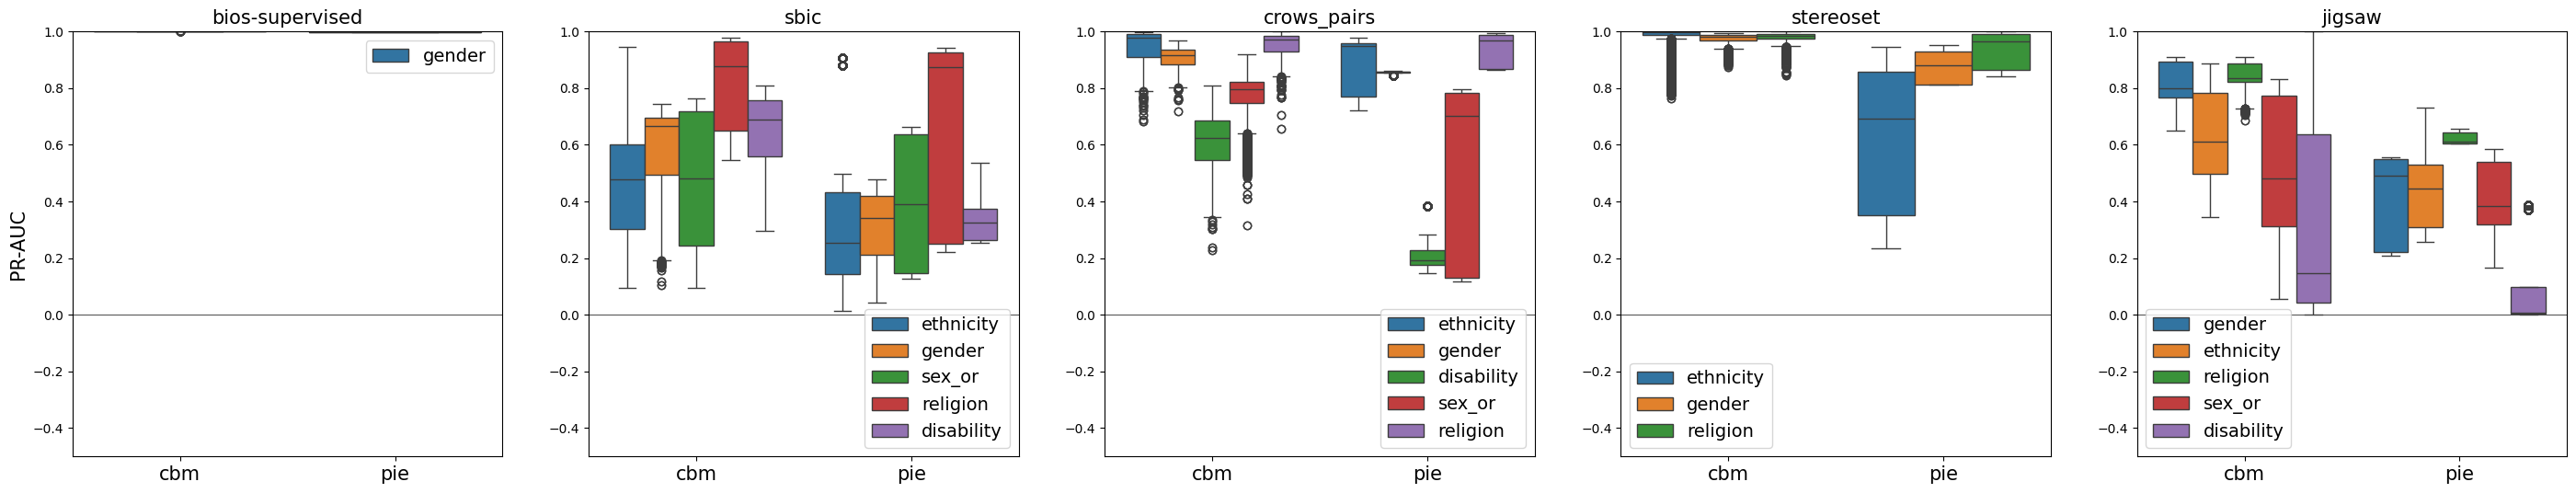

In [116]:
multipot(res_concept, subplot_col='dataset', xcol='method', ycol='PR-AUC', huecol='attribute', remove_legend=False)

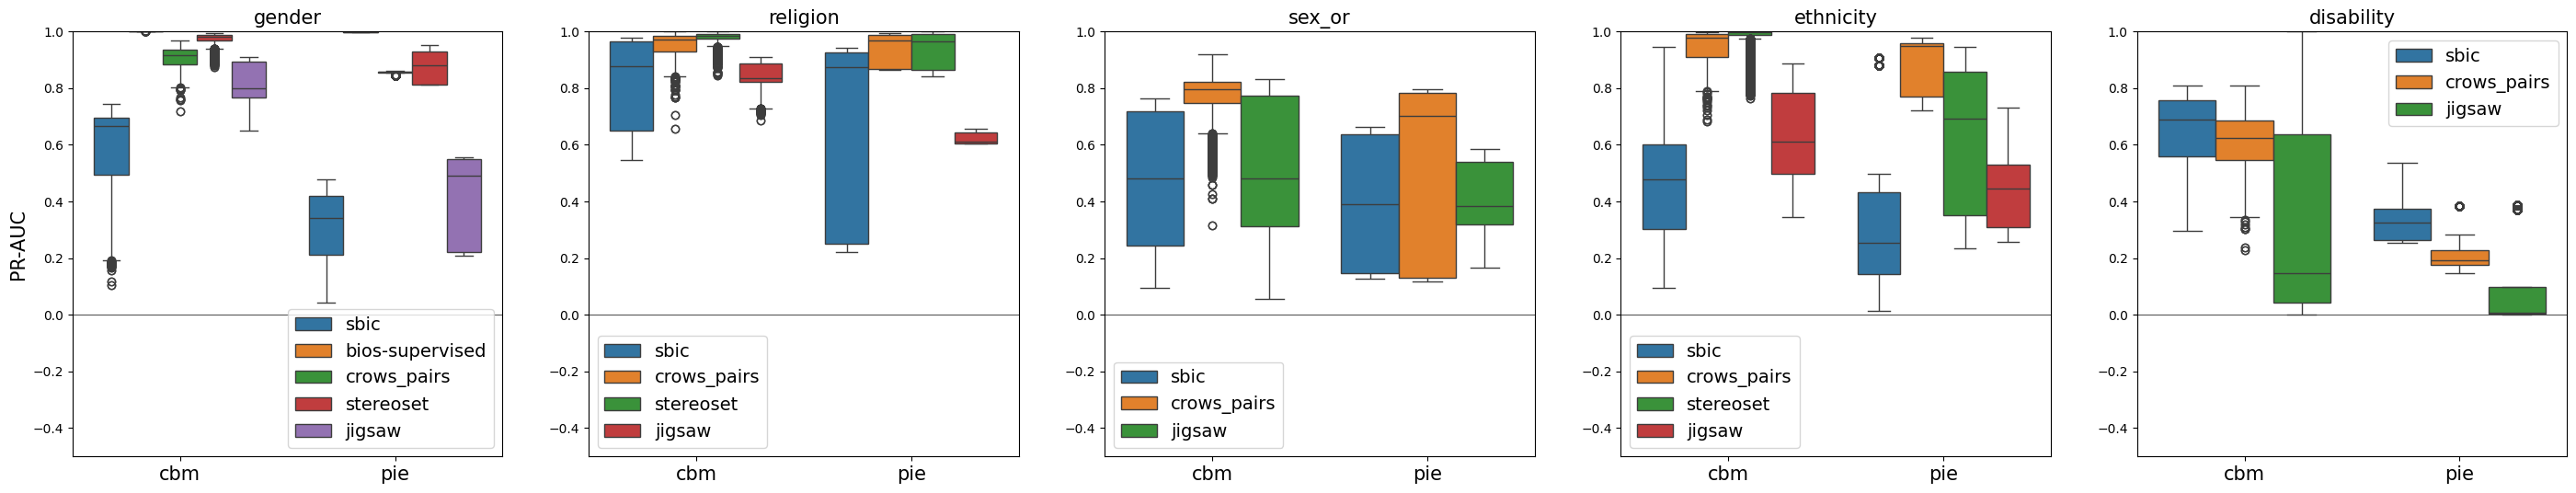

In [117]:
multipot(res_concept, subplot_col='attribute', xcol='method', ycol='PR-AUC', huecol='dataset', remove_legend=False)

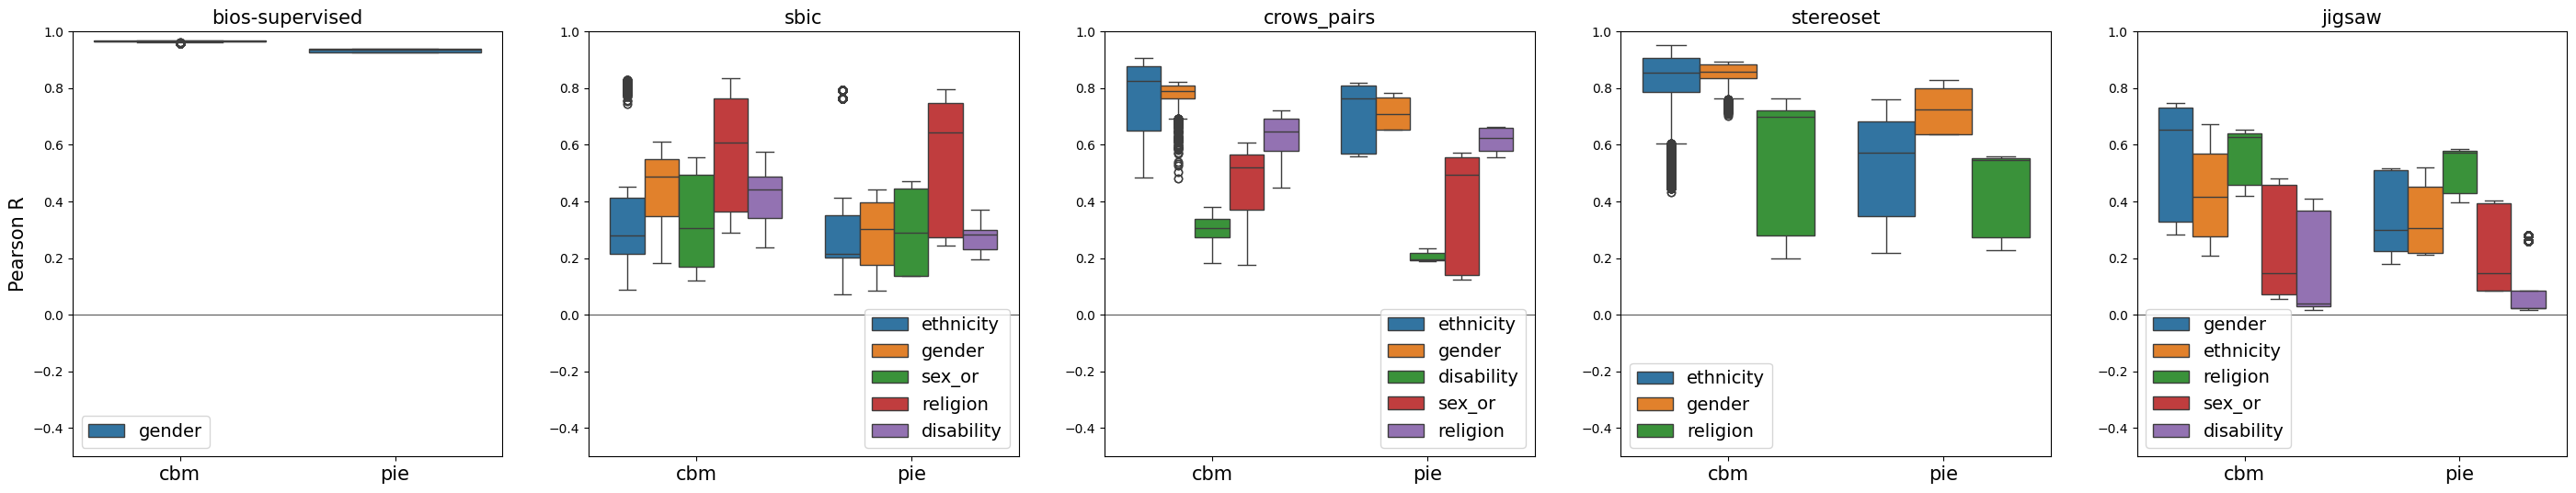

In [118]:
multipot(res_concept, subplot_col='dataset', xcol='method', ycol='Pearson R', huecol='attribute', remove_legend=False)

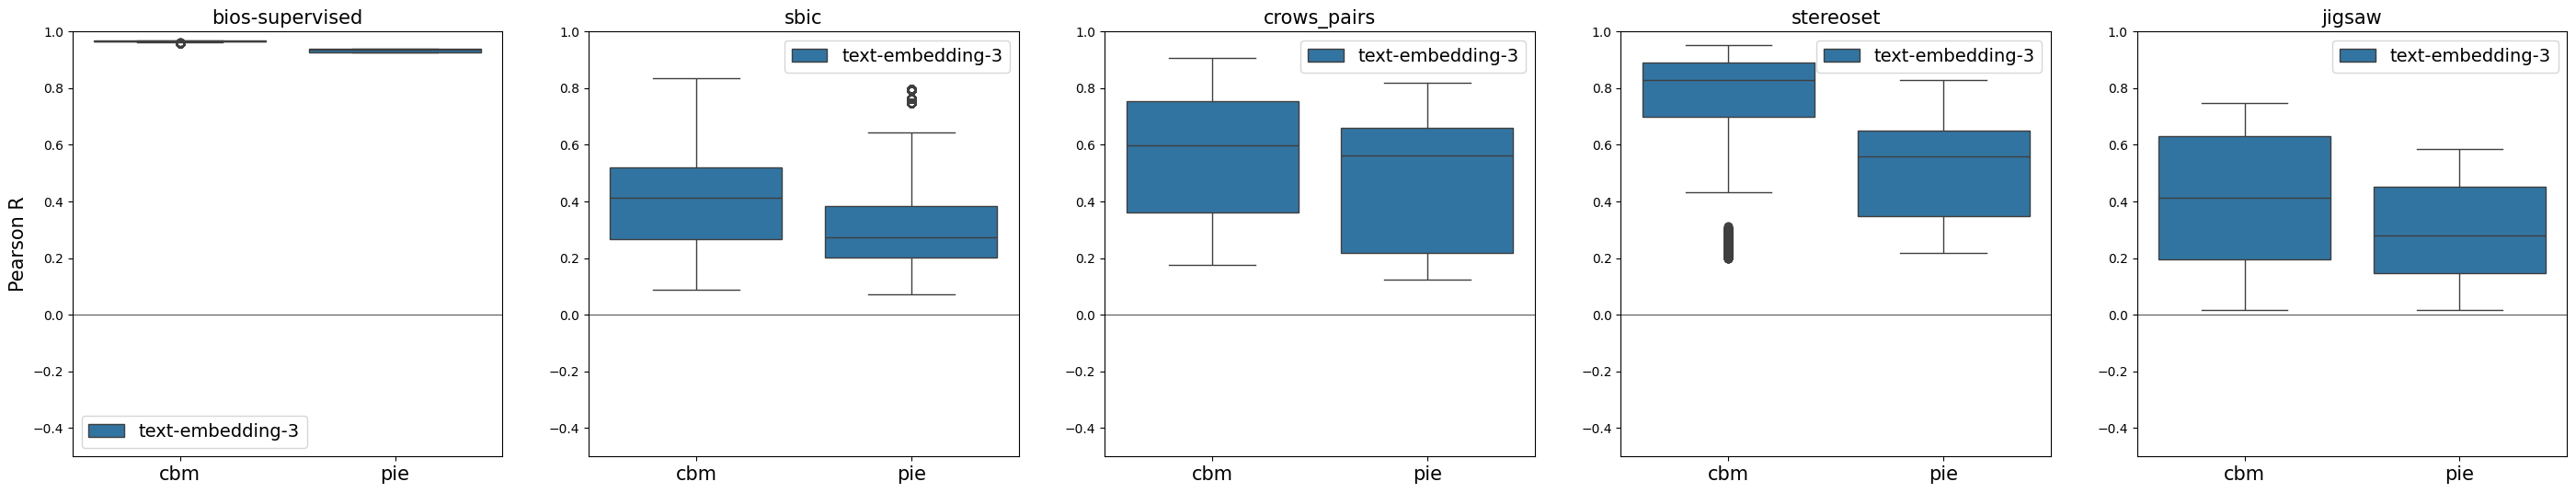

In [119]:
multipot(res_concept, subplot_col='dataset', xcol='method', ycol='Pearson R', huecol='model type', remove_legend=False)

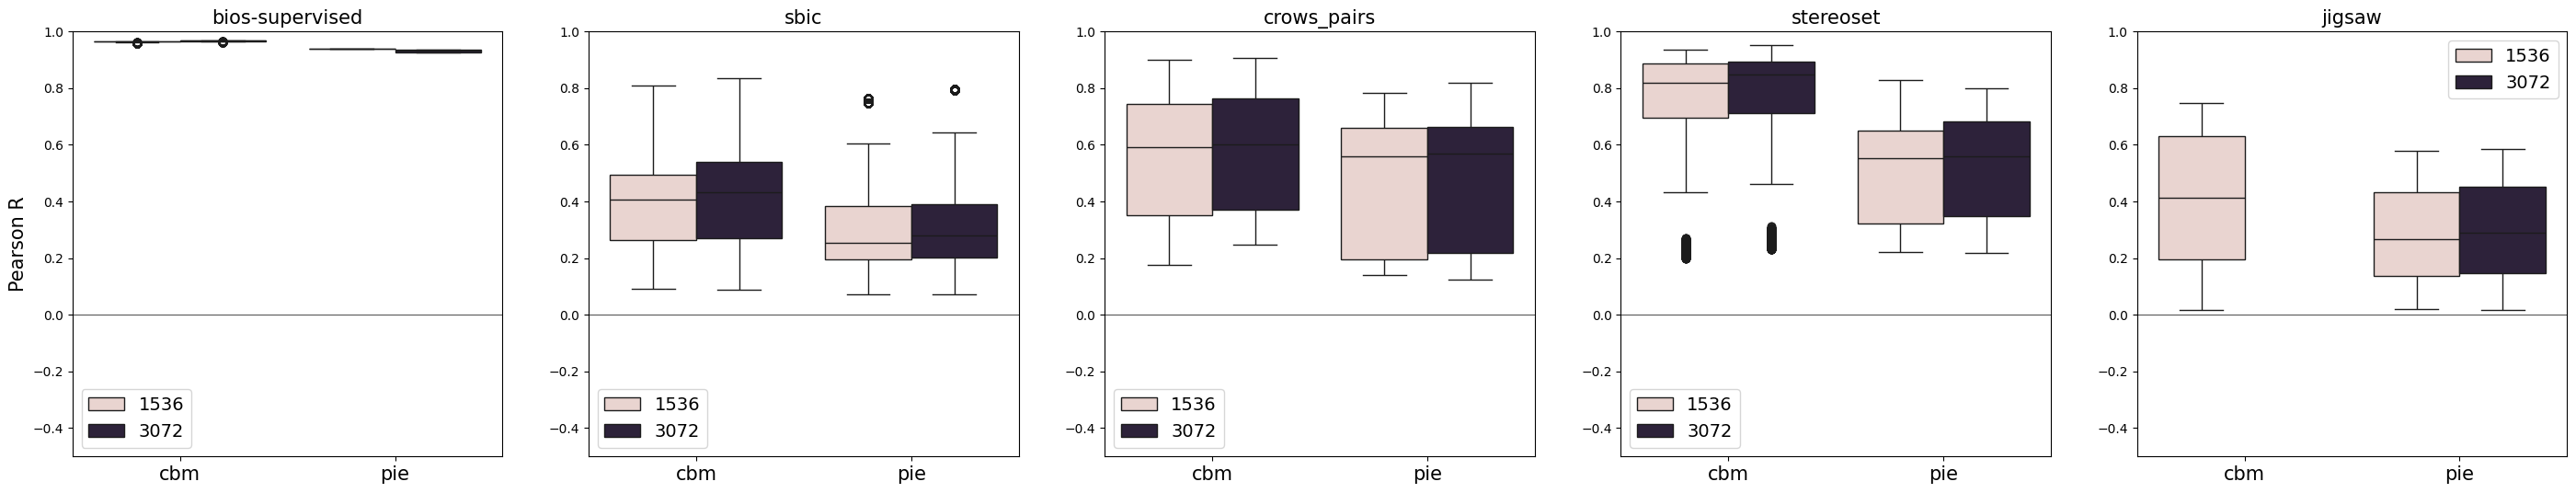

In [32]:
multipot(res_concept, subplot_col='dataset', xcol='method', ycol='Pearson R', huecol='emb size', remove_legend=False)

In [33]:
results_pie_concept[results_pie_concept['dataset'] == 'twitterAAE']

,index,dataset,model,model type,architecture,method,pooling,classifier,clf hidden size factor,emb size,...,optimizer,lr,loss,group (pie),group (test),Pearson R,pvalue,PR-AUC,Epochs,concepts


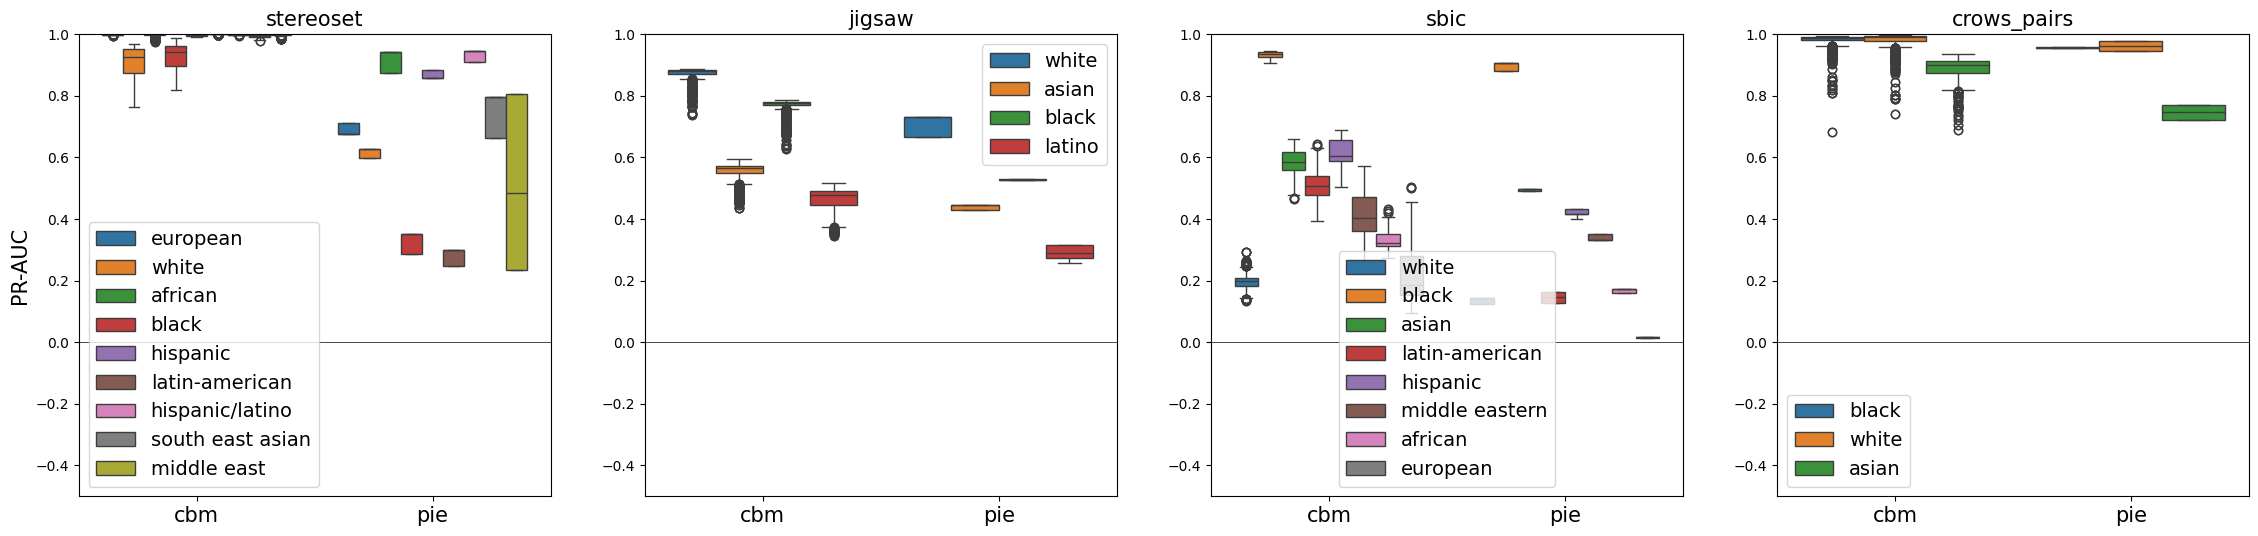

In [34]:
res = res_concept[res_concept['attribute'] == 'ethnicity']
multipot(res, subplot_col='dataset', xcol='method', ycol='PR-AUC', huecol='group (test)', remove_legend=False)

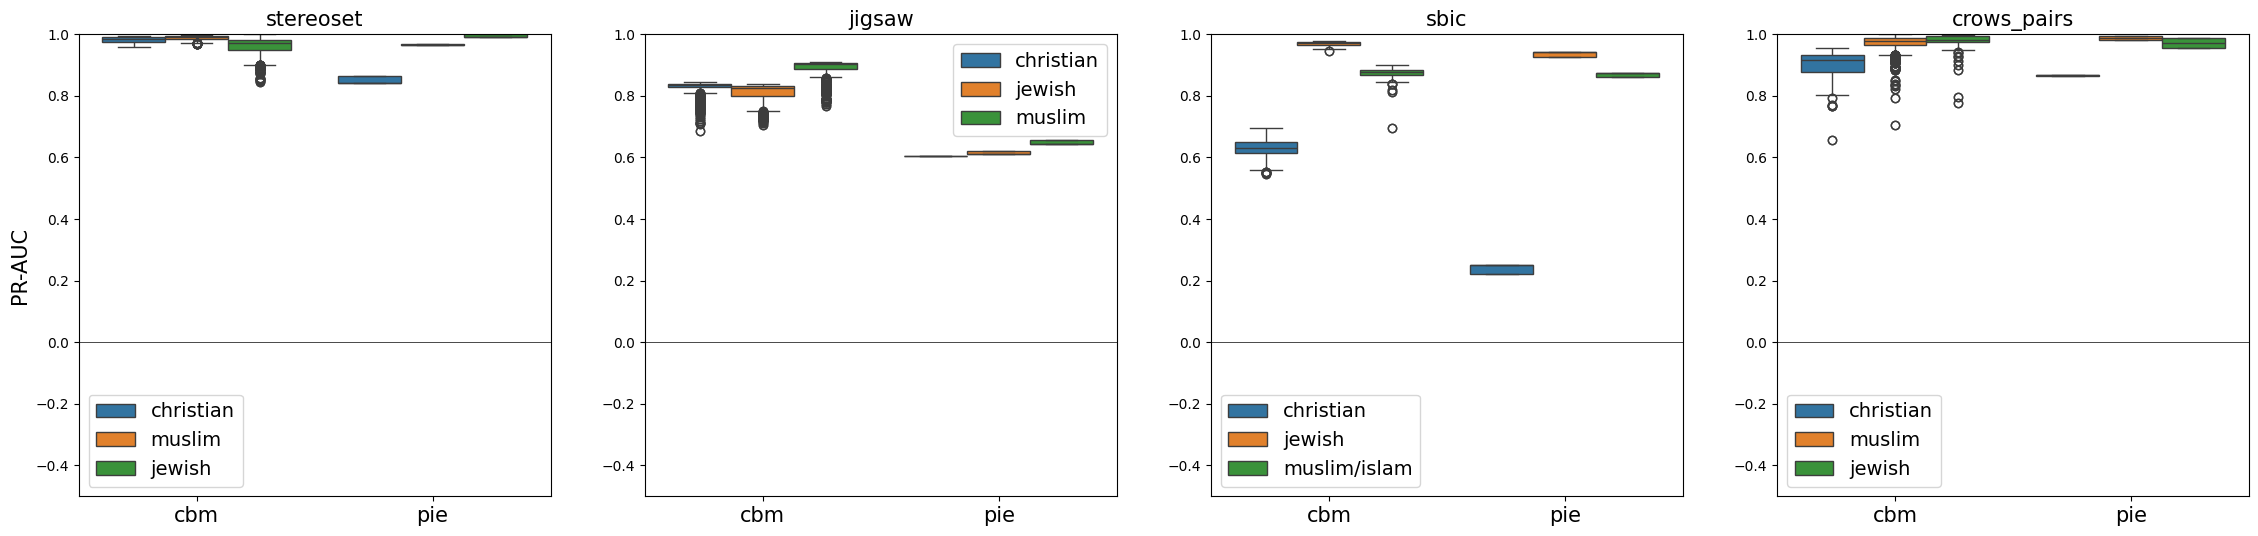

In [35]:
res = res_concept[res_concept['attribute'] == 'religion']
multipot(res, subplot_col='dataset', xcol='method', ycol='PR-AUC', huecol='group (test)', remove_legend=False)

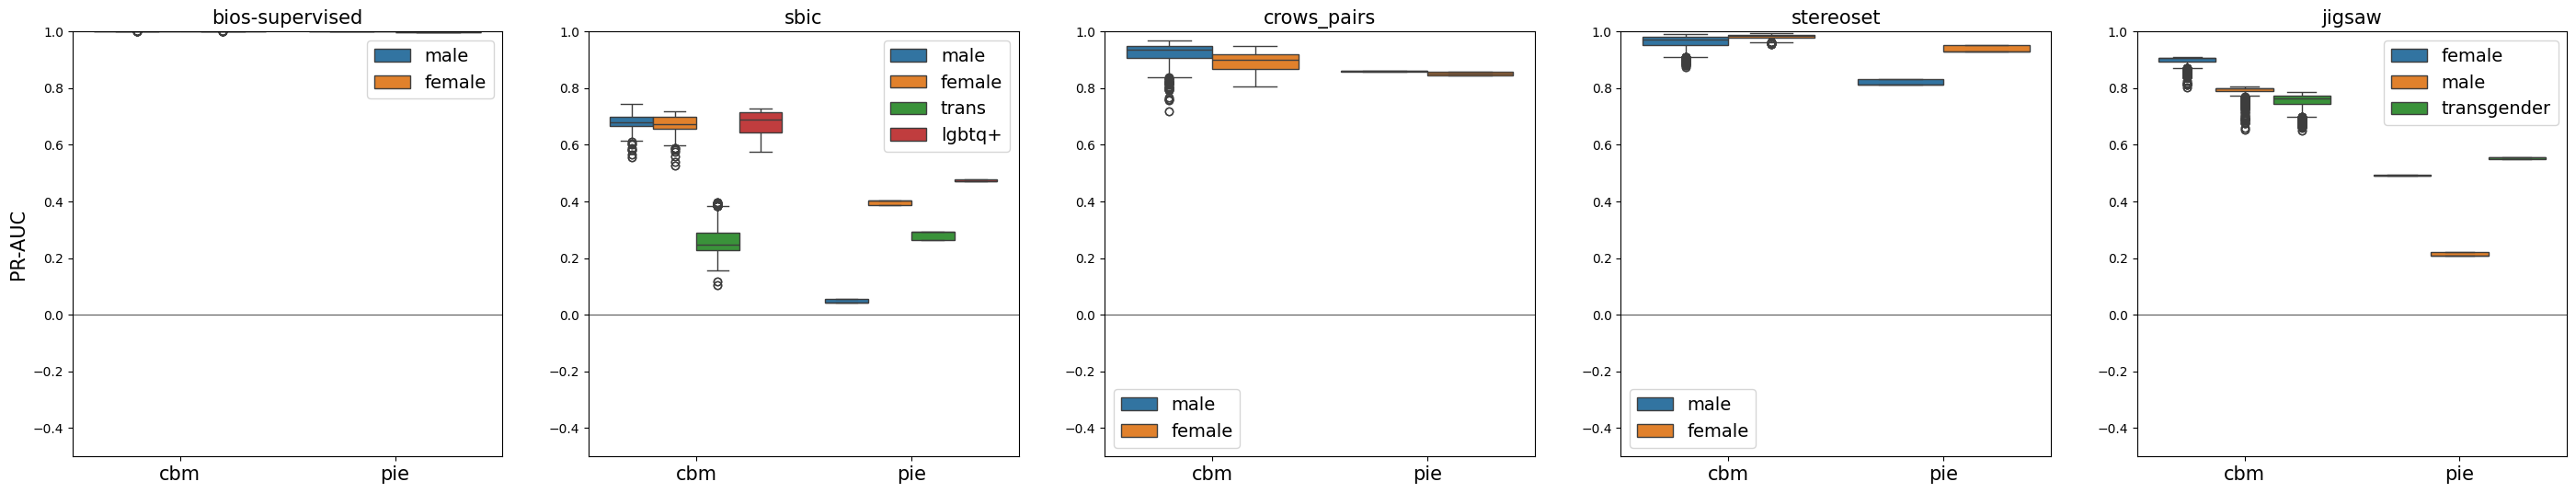

In [36]:
res = res_concept[res_concept['attribute'] == 'gender']
multipot(res, subplot_col='dataset', xcol='method', ycol='PR-AUC', huecol='group (test)', remove_legend=False)

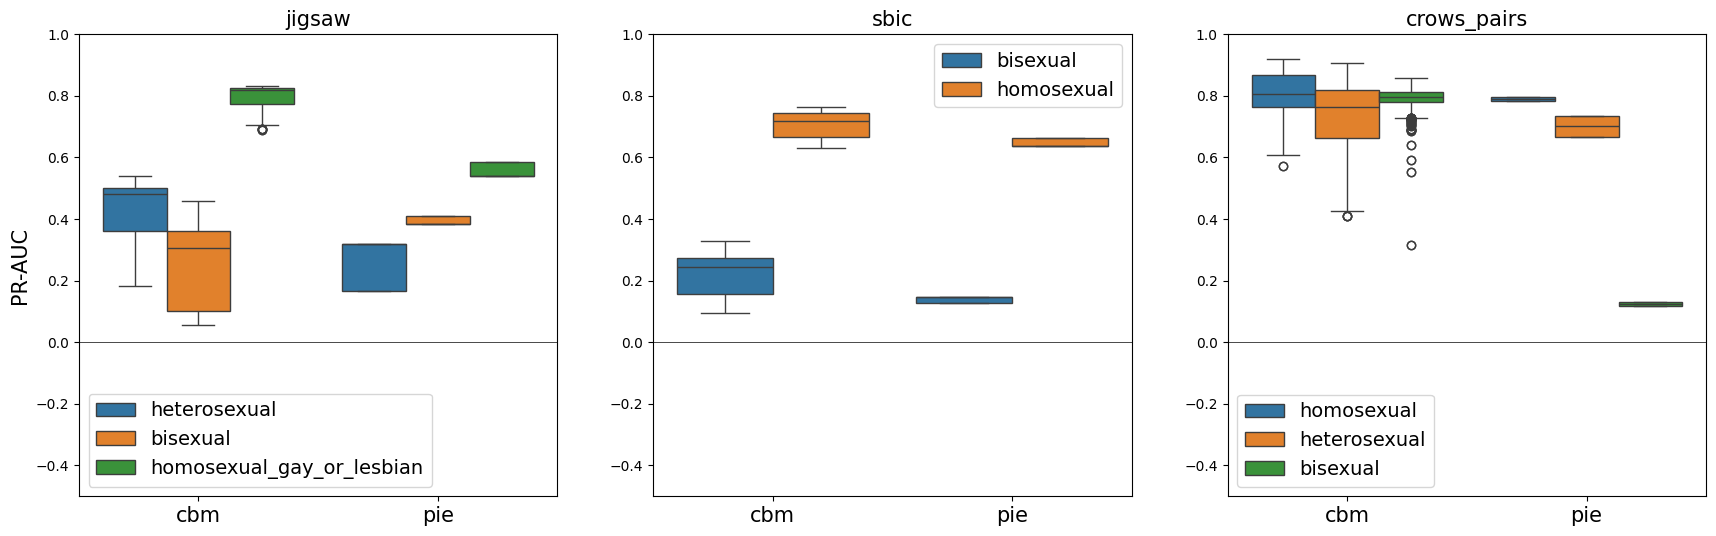

In [37]:
res = res_concept[res_concept['attribute'] == 'sex_or']
multipot(res, subplot_col='dataset', xcol='method', ycol='PR-AUC', huecol='group (test)', remove_legend=False)

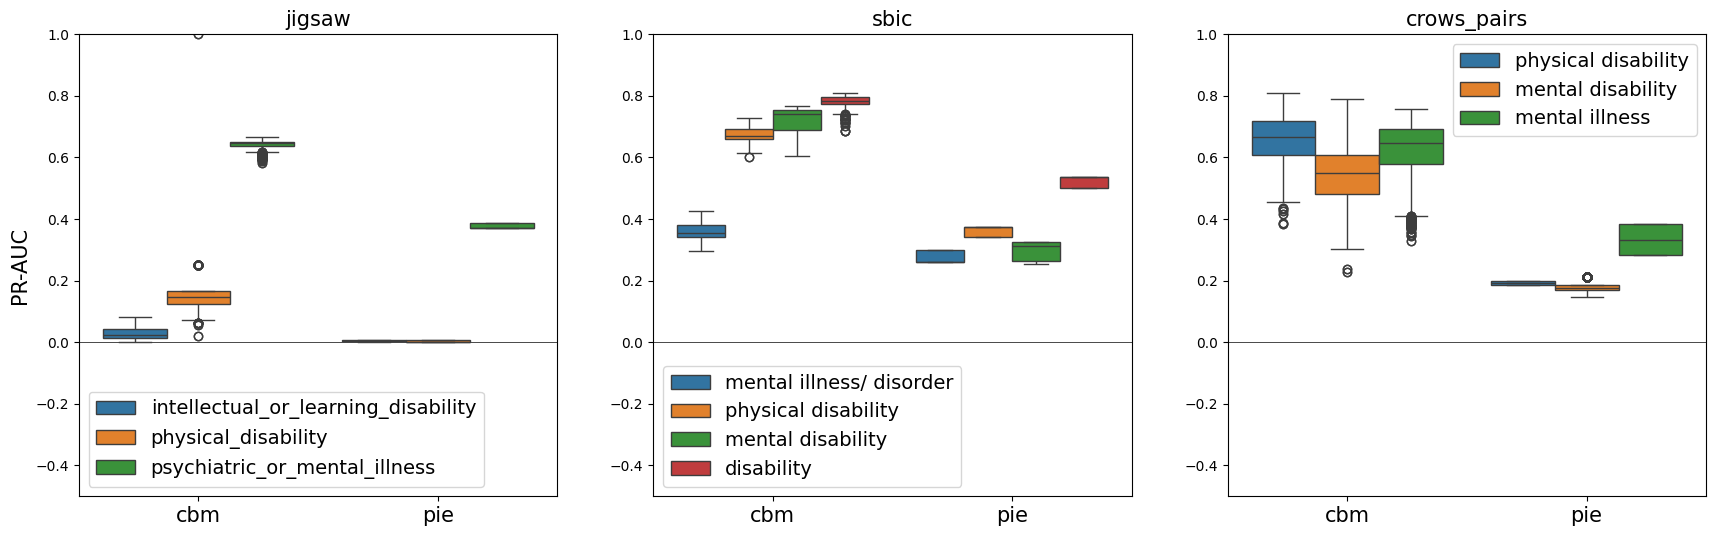

In [38]:
res = res_concept[res_concept['attribute'] == 'disability']
multipot(res, subplot_col='dataset', xcol='method', ycol='PR-AUC', huecol='group (test)', remove_legend=False)

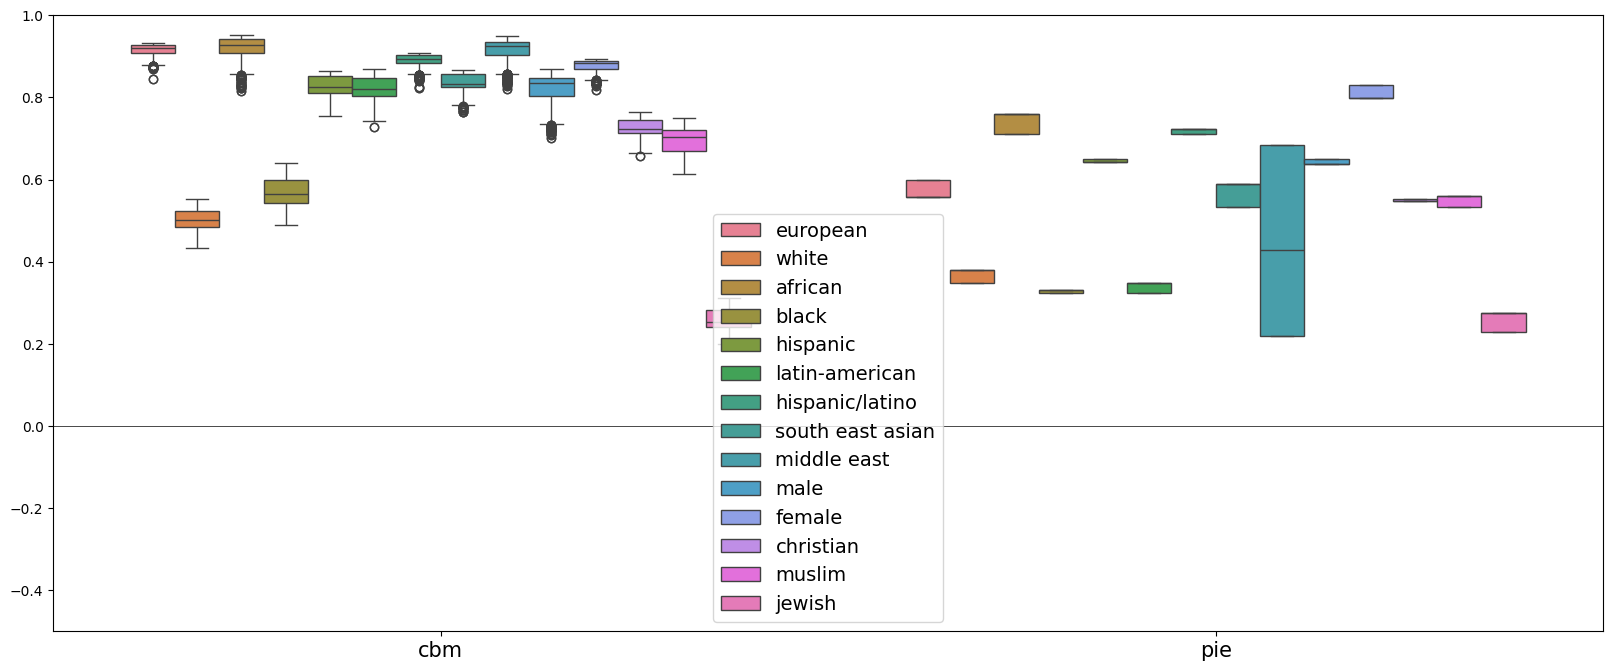

In [39]:
res = res_concept[res_concept['dataset'] == 'stereoset']

fig, ax = plt.subplots(figsize=(20,8))
boxplot(res, ax, xcol='method', ycol='Pearson R', huecol='group (test)', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

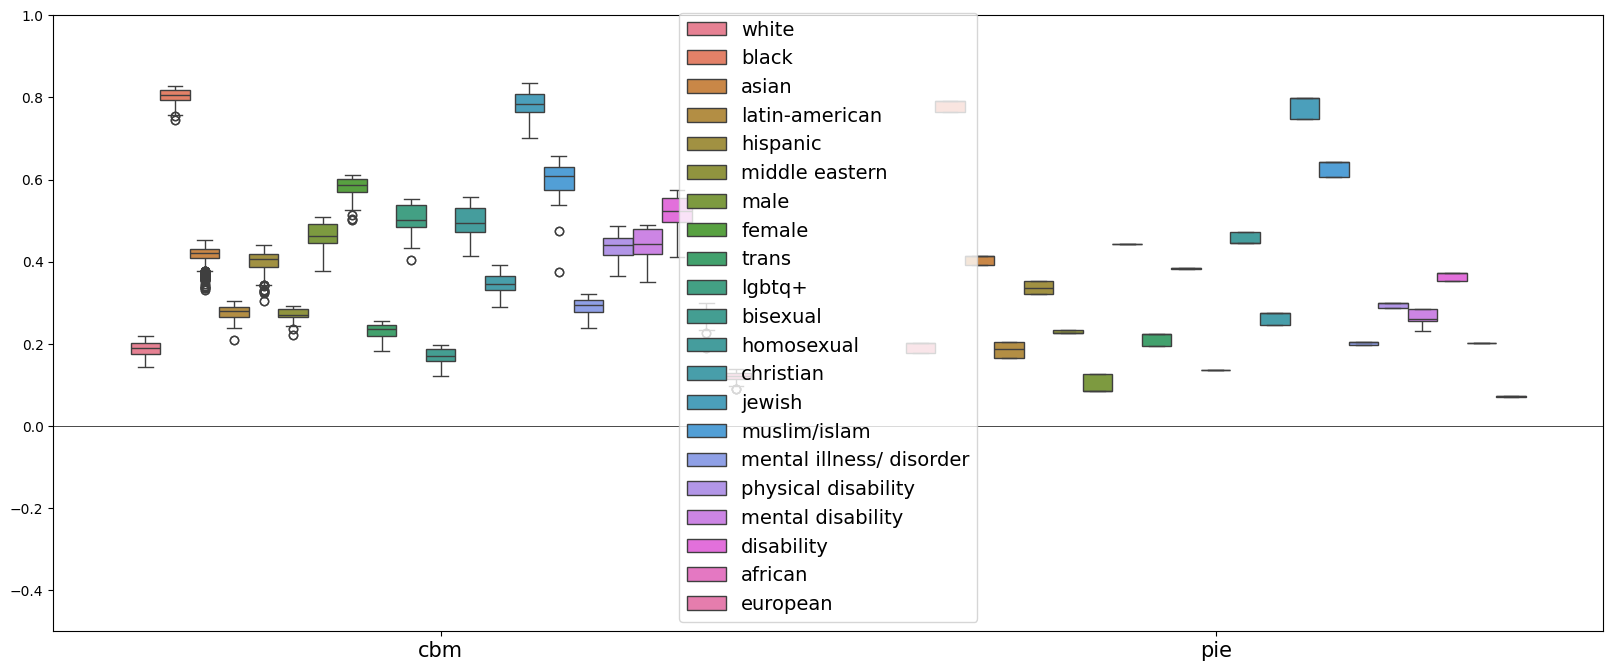

In [40]:
res = res_concept[res_concept['dataset'] == 'sbic']

fig, ax = plt.subplots(figsize=(20,8))
boxplot(res, ax, xcol='method', ycol='Pearson R', huecol='group (test)', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

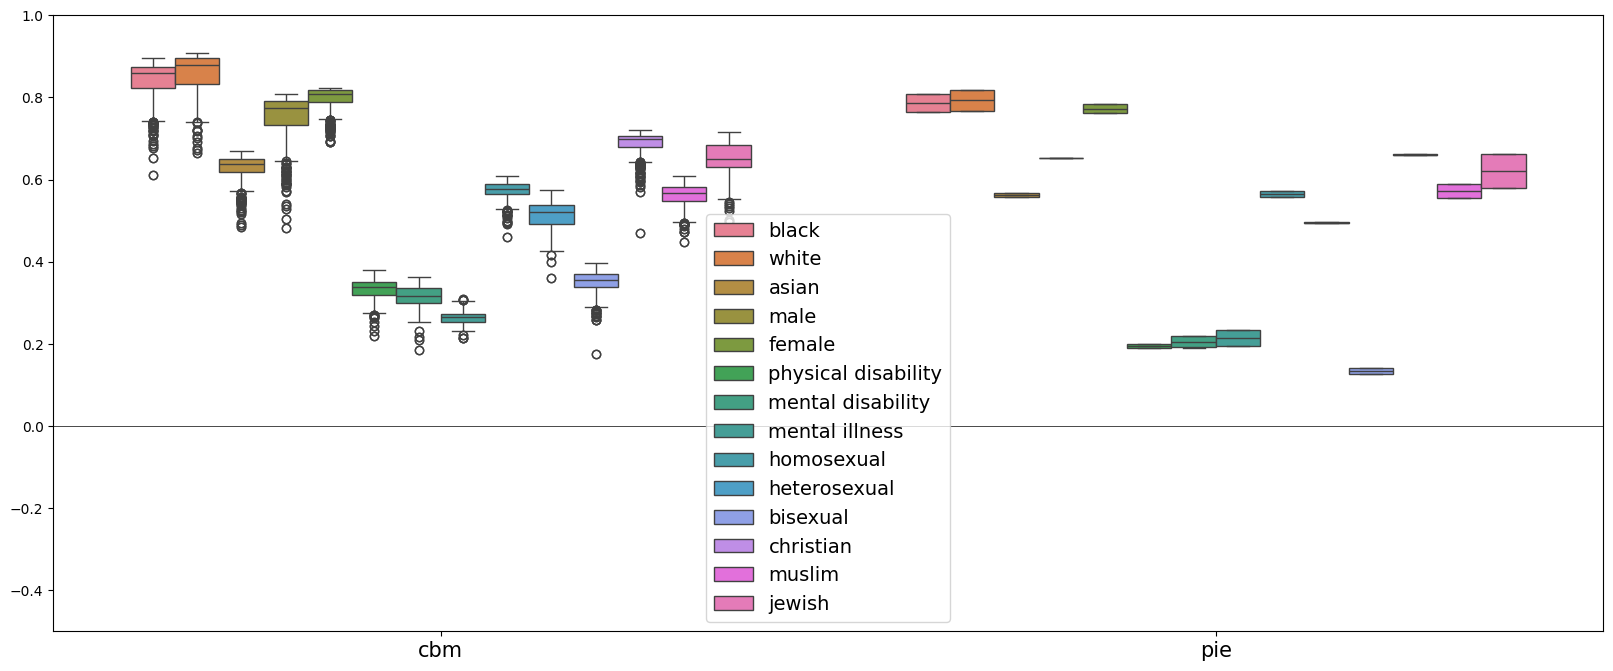

In [41]:
res = res_concept[res_concept['dataset'] == 'crows_pairs']

fig, ax = plt.subplots(figsize=(20,8))
boxplot(res, ax, xcol='method', ycol='Pearson R', huecol='group (test)', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

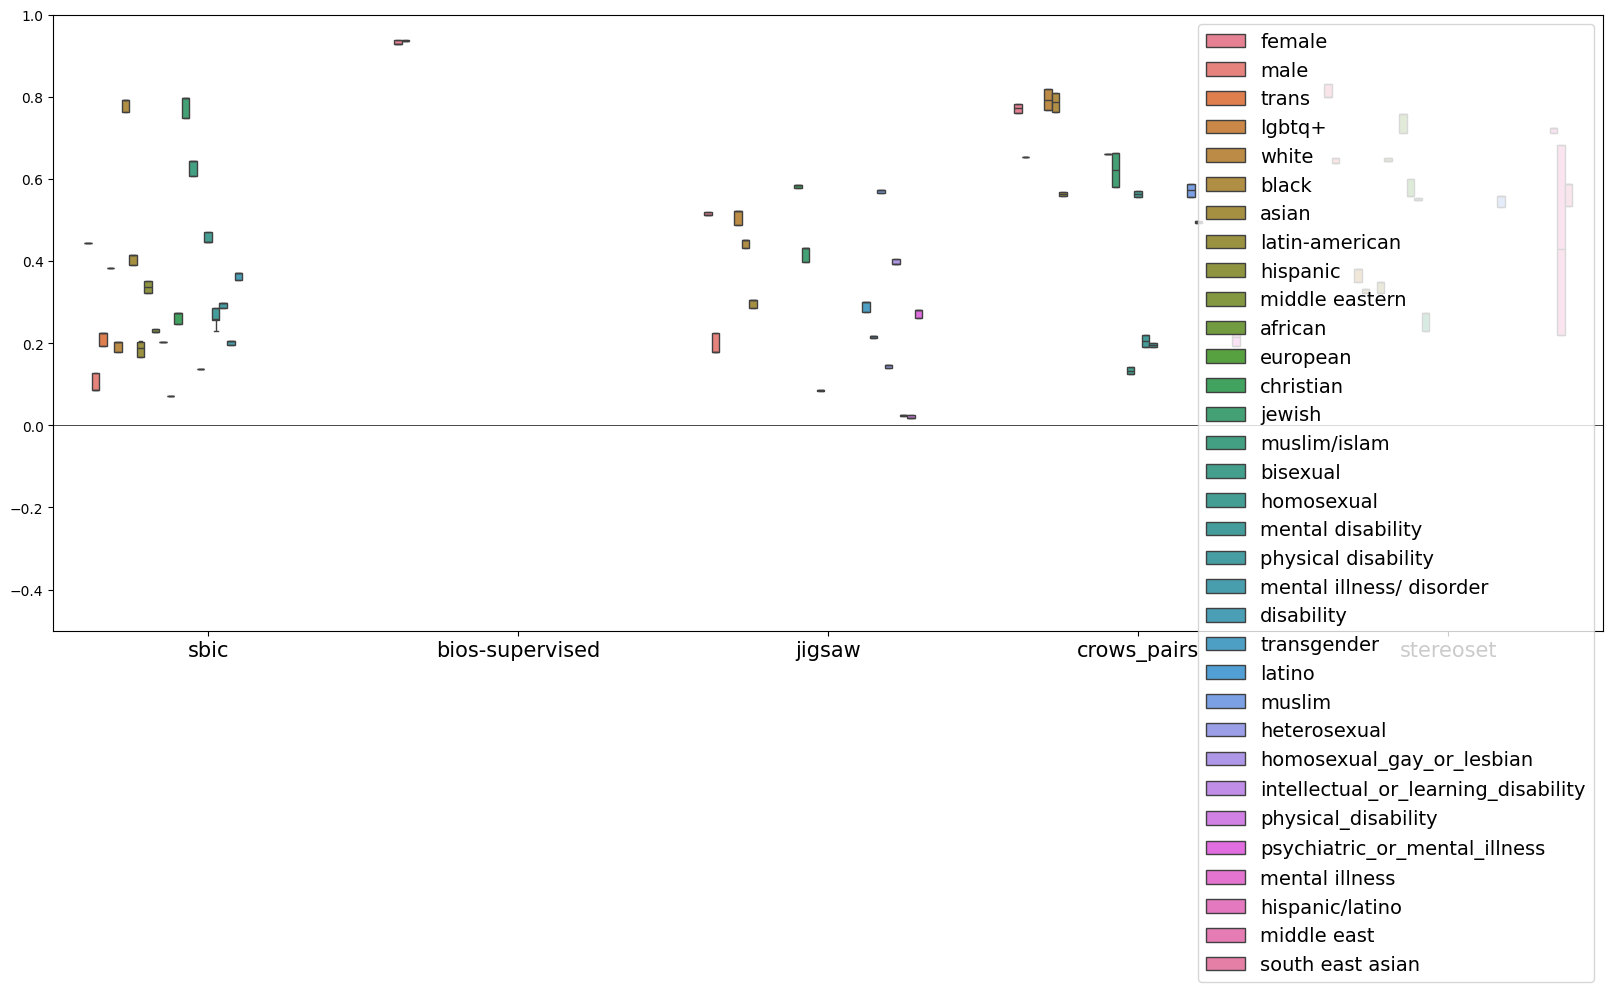

In [42]:
#res = res_concept[res_concept['dataset'] == 'crows_pairs']

fig, ax = plt.subplots(figsize=(20,8))
boxplot(results_pie_concept, ax, xcol='dataset', ycol='Pearson R', huecol='group (test)', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

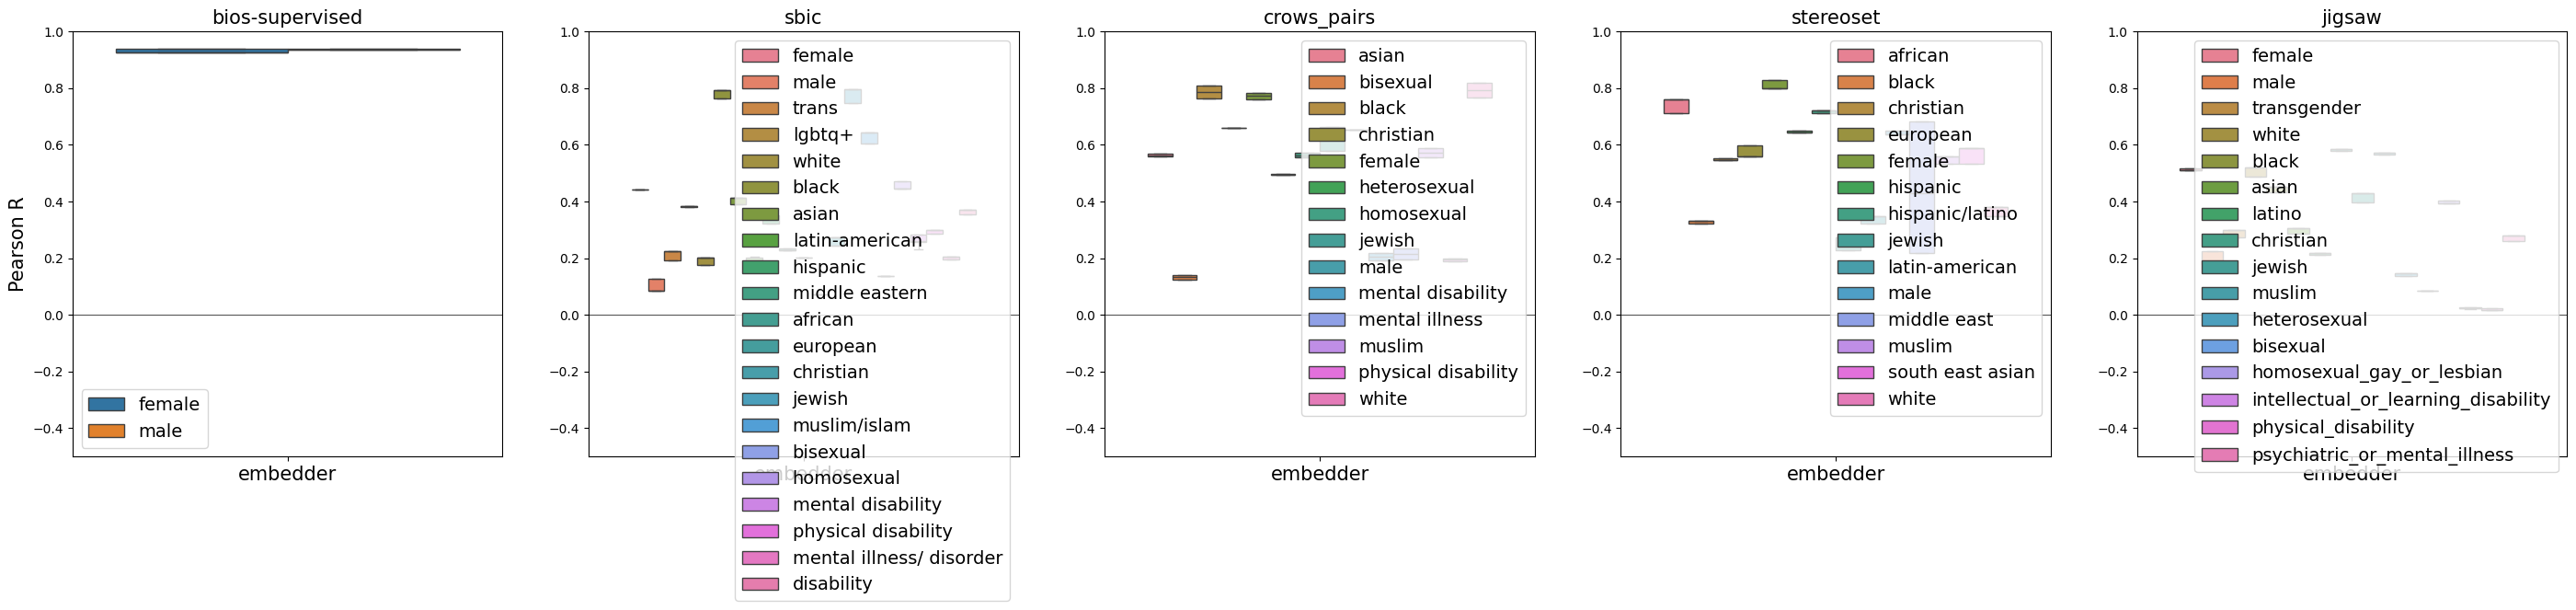

In [43]:
multipot(results_pie_concept, subplot_col='dataset', xcol='architecture', ycol='Pearson R', huecol='group (test)', remove_legend=False)

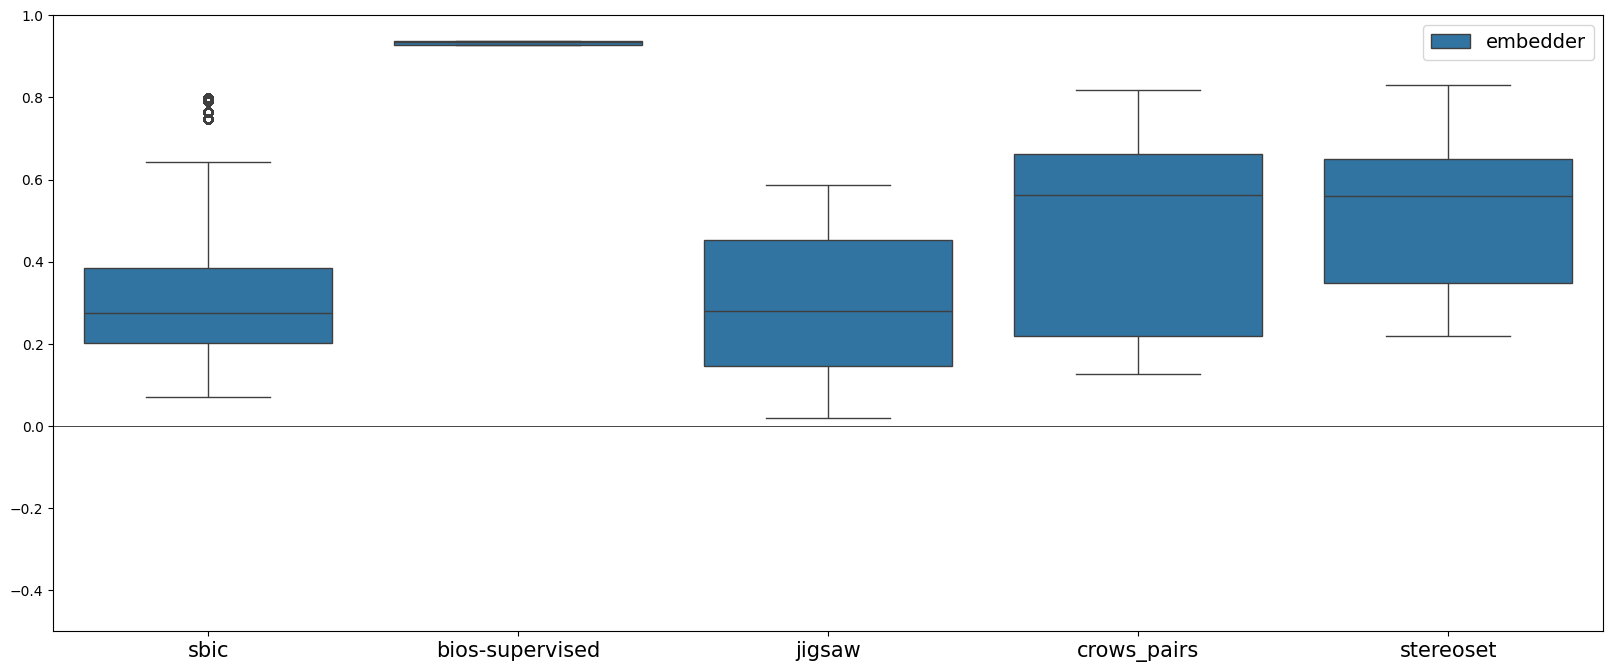

In [44]:
fig, ax = plt.subplots(figsize=(20,8))
boxplot(results_pie_concept, ax, xcol='dataset', ycol='Pearson R', huecol='architecture', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

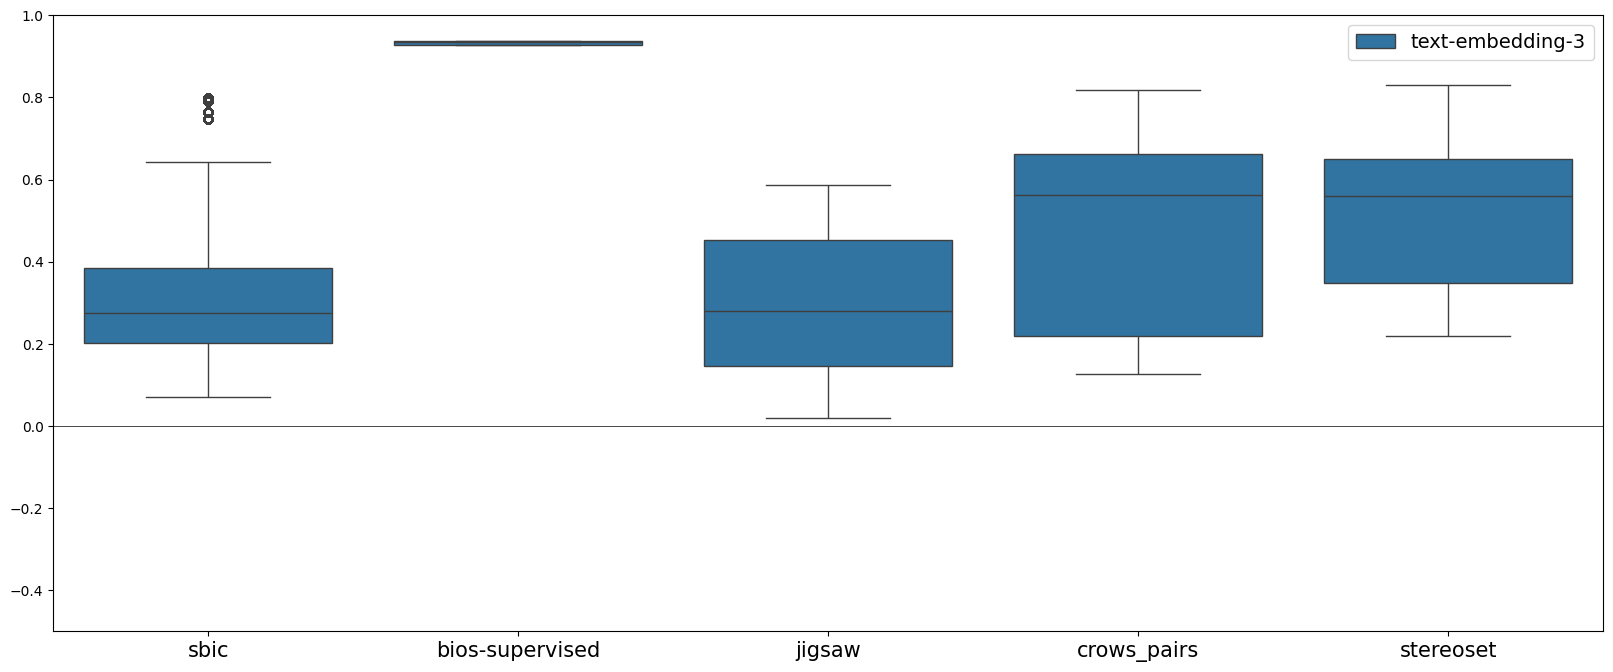

In [45]:
fig, ax = plt.subplots(figsize=(20,8))
boxplot(results_pie_concept, ax, xcol='dataset', ycol='Pearson R', huecol='model type', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

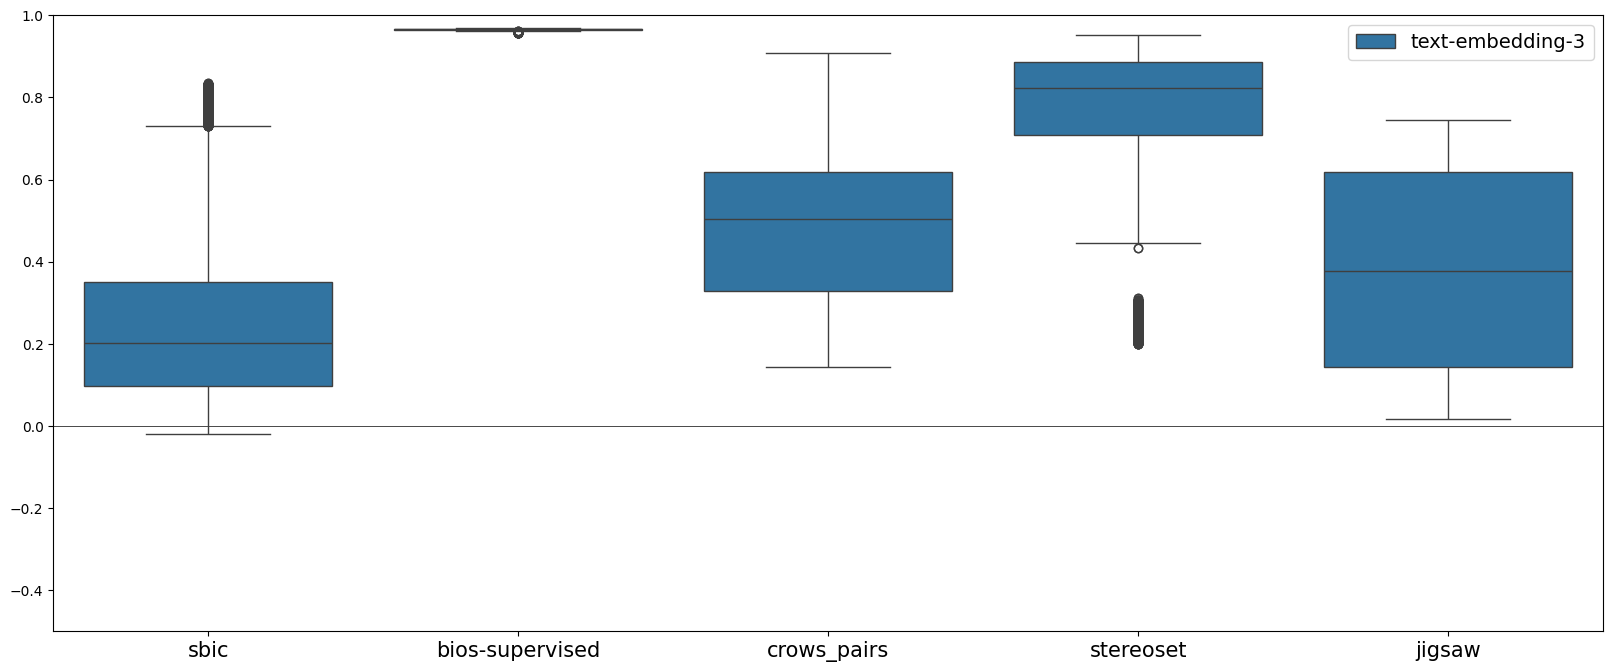

In [46]:
fig, ax = plt.subplots(figsize=(20,8))
boxplot(results_cbm_concept, ax, xcol='dataset', ycol='Pearson R', huecol='model type', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

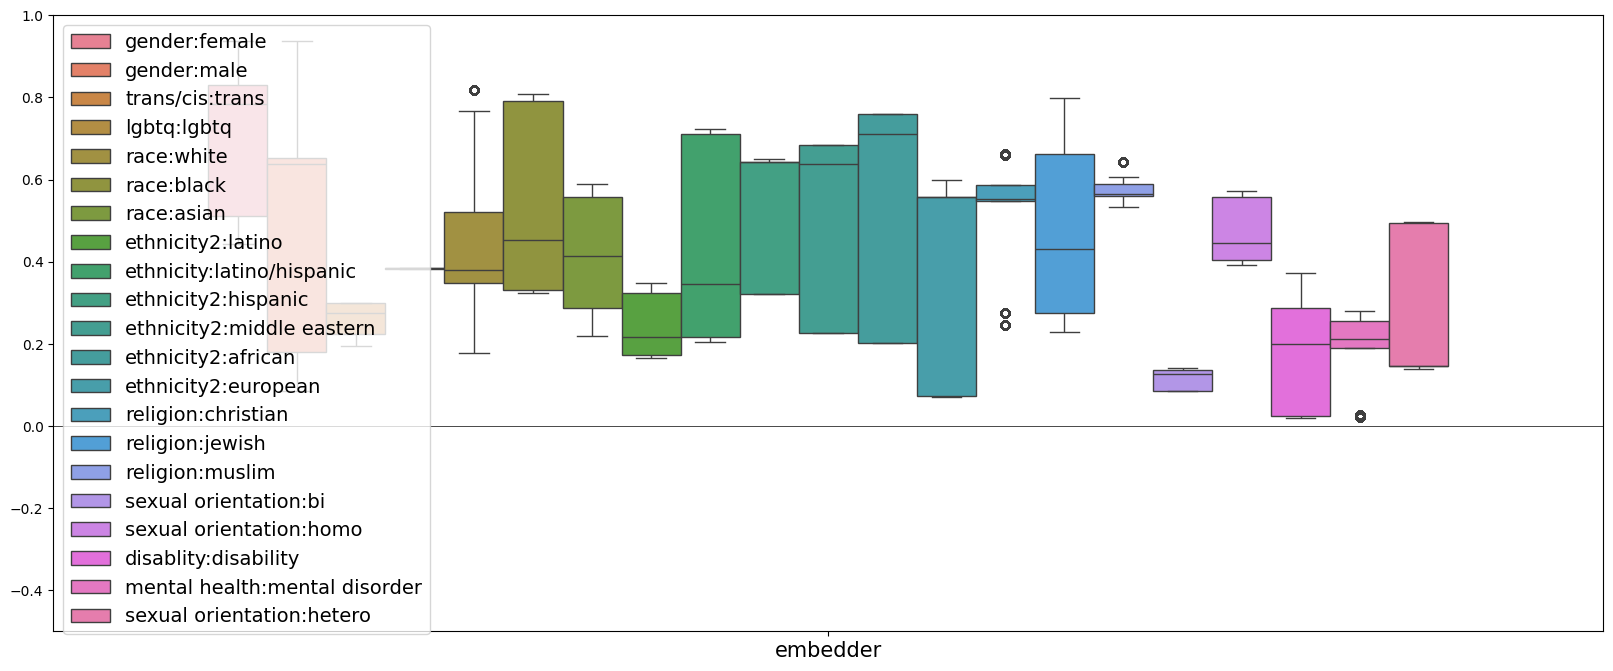

In [47]:
fig, ax = plt.subplots(figsize=(20,8))
boxplot(results_pie_concept, ax, xcol='architecture', ycol='Pearson R', huecol='group (pie)', title='', remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0)

In [125]:
set(results_pie_concept['model'])

{'EleutherAI/pythia-1.4b',
 'EleutherAI/pythia-160m',
 'EleutherAI/pythia-1b',
 'EleutherAI/pythia-410m',
 'albert-base-v2',
 'albert-large-v2',
 'bert-base-uncased',
 'bert-large-uncased',
 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B',
 'deepseek-ai/deepseek-llm-7b-base',
 'deepseek-ai/deepseek-llm-7b-chat',
 'distilbert-base-uncased',
 'distilgpt2',
 'distilroberta-base',
 'facebook/opt-1.3b',
 'facebook/opt-125m',
 'facebook/opt-350m',
 'google/electra-base-discriminator',
 'google/electra-base-generator',
 'google/electra-large-discriminator',
 'google/electra-large-generator',
 'gpt2',
 'gpt2-large',
 'gpt2-medium',
 'meta-llama/Llama-3.2-1B',
 'meta-llama/Llama-3.2-1B-Instruct',
 'meta-llama/Llama-3.2-3B',
 'meta-llama/Llama-3.2-3B-Instruct',
 'microsoft/deberta-v3-base',
 'microsoft/deberta-v3-large',
 'microsoft/deberta-v3-small',
 'roberta-base',
 'roberta-large',
 'xlnet/xlnet-base-cased',
 'xlnet/xlnet-large-cased'}